#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 : 
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 : 
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [3]:
data_path = os.path.join(os.getcwd(), 'data/data01_train.csv')
features_path = os.path.join(os.getcwd(), 'data/features.csv')

In [4]:
data = pd.read_csv(data_path)

In [5]:
features = pd.read_csv(features_path)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기 (data 로 진행)


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.
    - 데이터의 단변량 그래프를 그려서 데이터의 단변량 분석을 해 봅니다. 

In [6]:
#전체 데이터의 행,열 개수 확인
# 5881개의 데이터 (ROW)
# 563개의 변수, feaure (COL) -> tBodyAcc-mean()-X 부터 Activity까지
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


In [7]:
#전체 데이터의 상위 5개 행 확인
data.head(5)

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288508          -0.009196          -0.103362         -0.988986   
1           0.265757          -0.016576          -0.098163         -0.989551   
2           0.278709          -0.014511          -0.108717         -0.997720   
3           0.289795          -0.035536          -0.150354         -0.231727   
4           0.394807           0.034098           0.091229          0.088489   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.962797         -0.967422         -0.989000         -0.962596   
1         -0.994636         -0.987435         -0.990189         -0.993870   
2         -0.981088         -0.994008         -0.997934         -0.982187   
3         -0.006412         -0.338117         -0.273557          0.014245   
4         -0.106636         -0.388502         -0.010469         -0.109680   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-kurtosis()  \
0         -0.965650         -0.929747  ...                        -0.816696   
1         -0.987558         -0.937337  ...                        -0.693515   
2         -0.995017         -0.942584  ...                        -0.829311   
3         -0.347916          0.008288  ...                        -0.408956   
4         -0.346372          0.584131  ...                        -0.563437   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                    -0.042494                             -0.044218   
1                    -0.062899                              0.388459   
2                     0.000265                             -0.525022   
3                    -0.255125                              0.612804   
4                    -0.044344                             -0.845268   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                          0.307873                              0.072790   
1                         -0.765014                              0.771524   
2                         -0.891875                              0.021528   
3                          0.747381                             -0.072944   
4                         -0.974650                             -0.887846   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  subject  \
0             -0.601120              0.331298              0.165163       21   
1              0.345205             -0.769186             -0.147944       15   
2             -0.833564              0.202434             -0.032755       11   
3             -0.695819              0.287154              0.111388       17   
4             -0.705029              0.264952              0.137758       17   

             Activity  
0            STANDING  
1              LAYING  
2            STANDING  
3             WALKING  
4  WALKING_DOWNSTAIRS  

[5 rows x 563 columns]

In [8]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        5881.000000        5881.000000        5881.000000   
mean            0.274811          -0.017799          -0.109396   
std             0.067614           0.039422           0.058373   
min            -0.503823          -0.684893          -1.000000   
25%             0.262919          -0.024877          -0.121051   
50%             0.277154          -0.017221          -0.108781   
75%             0.288526          -0.010920          -0.098163   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       5881.000000       5881.000000       5881.000000       5881.000000   
mean          -0.603138         -0.509815         -0.604058         -0.628151   
std            0.448807          0.501815          0.417319          0.424345   
min           -1.000000         -0.999844         -0.999667         -1.000000   
25%           -0.992774         -0.977680         -0.980127         -0.993602   
50%           -0.943933         -0.844575         -0.856352         -0.948501   
75%           -0.242130         -0.034499         -0.262690         -0.291138   
max            1.000000          0.916238          1.000000          1.000000   

       tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
count       5881.000000       5881.000000       5881.000000  ...   
mean          -0.525944         -0.605374         -0.465490  ...   
std            0.485115          0.413043          0.544995  ...   
min           -0.999419         -1.000000         -1.000000  ...   
25%           -0.977865         -0.980112         -0.936067  ...   
50%           -0.849266         -0.849896         -0.878729  ...   
75%           -0.068857         -0.268539         -0.013690  ...   
max            0.967664          1.000000          1.000000  ...   

       fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
count                      5881.000000                      5881.000000   
mean                         -0.305883                        -0.623548   
std                           0.322808                         0.310371   
min                          -0.979261                        -0.999765   
25%                          -0.541969                        -0.845985   
50%                          -0.342923                        -0.712677   
75%                          -0.127371                        -0.501158   
max                           0.989538                         0.956845   

       angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
count                  5881.000000                           5881.000000   
mean                      0.008524                             -0.001185   
std                       0.339730                              0.447197   
min                      -0.976580                             -1.000000   
25%                      -0.122361                             -0.294369   
50%                       0.010278                              0.005146   
75%                       0.154985                              0.285030   
max                       1.000000                              1.000000   

       angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
count                       5881.000000                           5881.000000   
mean                           0.009340                             -0.007099   
std                            0.608190                              0.476738   
min                           -1.000000                             -1.000000   
25%                           -0.481718                             -0.373345   
50%                            0.011448                             -0.000847   
75%                            0.499857                              0.356236   
max                            0.998702                     

In [9]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

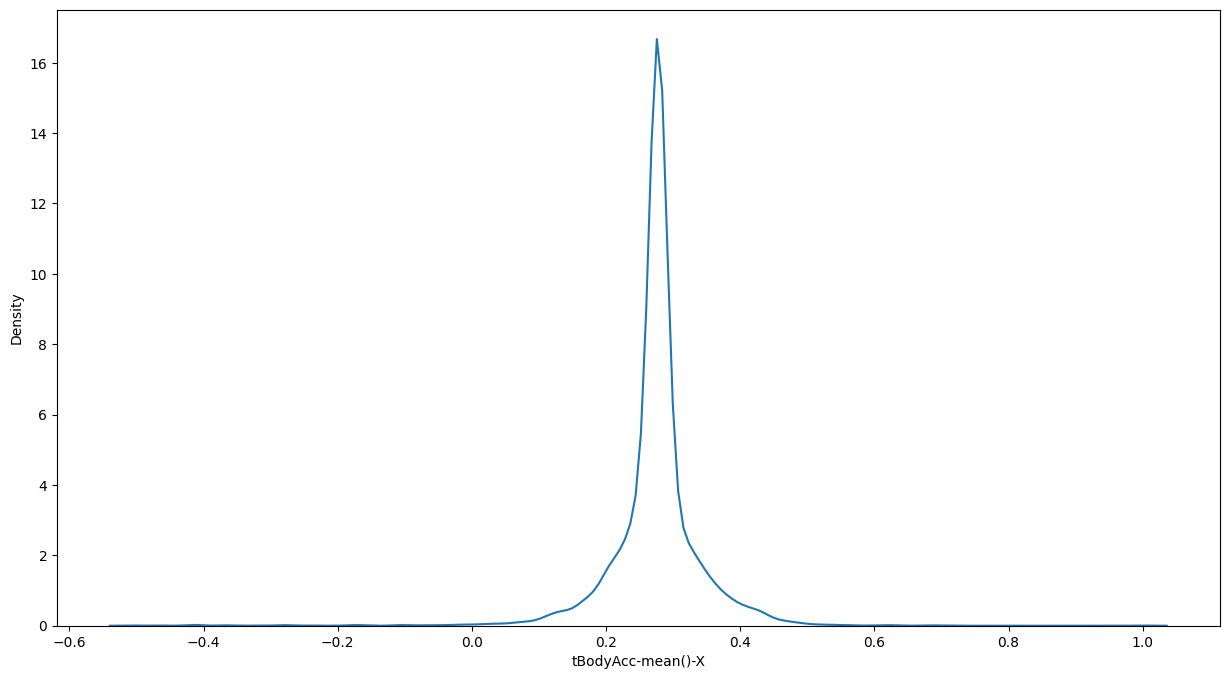

Mean: 0.2748109333760755
Mode: 0
Median: 0.27715407



In [10]:
# kde로 tBodyAcc-mean()-X 분포 확인하기 (단변량 분석) - 예제 일뿐 다양한 방법과 다양한 변수로 단변량 그래프를 그려보세요.
var = 'tBodyAcc-mean()-X'
plt.figure(figsize=(15,8))
sns.kdeplot(x=var, data=data, common_norm=False)
plt.show()

var = data[var]
# Mode는 argmax 과정에서 0으로 근사화 되긴 함
# 모양과 분포를 확인해보니 가우시안 분포
print(f'Mean: {np.mean(var)}\nMode: {np.bincount(var).argmax()}\nMedian: {np.median(var)}\n')

In [11]:
# 전체 데이터의 이변량 분석 (corr)
# Activity 숫자로 변환
data['Activity_num'] = data['Activity'].map({'WALKING': 0,
                                             'WALKING_UPSTAIRS': 1,
                                             'WALKING_DOWNSTAIRS': 2,
                                             'LAYING': 3,
                                             'STANDING': 4,
                                             'SITTING': 5 })
df = data.drop('Activity', axis=1)
corr = df.corr()
corr

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
tBodyAcc-mean()-X              1.000000           0.203297          -0.266383   
tBodyAcc-mean()-Y              0.203297           1.000000          -0.145709   
tBodyAcc-mean()-Z             -0.266383          -0.145709           1.000000   
tBodyAcc-std()-X               0.012067          -0.049467          -0.024839   
tBodyAcc-std()-Y              -0.018489          -0.052489          -0.017613   
...                                 ...                ...                ...   
angle(X,gravityMean)          -0.027010           0.000039           0.007045   
angle(Y,gravityMean)           0.028177           0.002376          -0.017900   
angle(Z,gravityMean)           0.019025          -0.022329          -0.019169   
subject                        0.027597           0.006299          -0.000459   
Activity_num                   0.012249           0.065975           0.045042   

                      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  \
tBodyAcc-mean()-X             0.012067         -0.018489         -0.040405   
tBodyAcc-mean()-Y            -0.049467         -0.052489         -0.058499   
tBodyAcc-mean()-Z            -0.024839         -0.017613         -0.016924   
tBodyAcc-std()-X              1.000000          0.927809          0.851841   
tBodyAcc-std()-Y              0.927809          1.000000          0.893995   
...                                ...               ...               ...   
angle(X,gravityMean)         -0.373500         -0.380258         -0.346237   
angle(Y,gravityMean)          0.470834          0.521249          0.473572   
angle(Z,gravityMean)          0.392843          0.429141          0.480593   
subject                      -0.055562         -0.107235         -0.041947   
Activity_num                 -0.729811         -0.814393         -0.771374   

                      tBodyAcc-mad()-X  tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  \
tBodyAcc-mean()-X             0.018367         -0.019752         -0.043303   
tBodyAcc-mean()-Y            -0.048703         -0.053018         -0.058559   
tBodyAcc-mean()-Z            -0.023323         -0.015794         -0.012575   
tBodyAcc-std()-X              0.998656          0.921154          0.846308   
tBodyAcc-std()-Y              0.923386          0.997320          0.892843   
...                                ...               ...               ...   
angle(X,gravityMean)         -0.370024         -0.376665         -0.348279   
angle(Y,gravityMean)          0.466287          0.522401          0.474880   
angle(Z,gravityMean)          0.389196          0.427486          0.477848   
subject                      -0.054814         -0.106383         -0.047428   
Activity_num                 -0.725476         -0.814512         -0.775233   

                      tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-kurtosis()  \
tBodyAcc-mean()-X             0.048725  ...                        -0.011490   
tBodyAcc-mean()-Y            -0.038544  ...                        -0.003467   
tBodyAcc-mean()-Z            -0.040397  ...                         0.018234   
tBodyAcc-std()-X              0.981190  ...                         0.116425   
tBodyAcc-std()-Y              0.916853  ...                         0.177232   
...                                ...  ...                              ...   
angle(X,gravityMean)         -0.385300  ...                        -0.080113   
angle(Y,gravityMean)          0.478832  ...                         0.080726   
angle(Z,gravityMean)          0.401217  ...                         0.049690   
subject                      -0.045658  ...                        -0.036173   
Activity_num                 -0.730359  ...                        -0.228656   

                      angle(tBodyAccMean,gravity)  \
tBodyAcc-mean()-X                       -0.567455   
tBodyAcc-mean()-Y                        0.076995   
tBodyAcc-mean()-Z                        0.056806   
tB

#### 시각화하기엔 너무 많기 때문에 Target Col과의 corr을 기준으로 상위 5개와 하위 5개만 추출해 시각화
* 참고로, 최상위는 자기 자신이 나올 것이니 상위는 6개를 선택함

In [12]:
# 이변량 시각화 하기  (변수를 줄여서 해보는 것도 의미 있겠죠?)
top_6_corr = corr['Activity_num'].abs().nlargest(6)
for col, val in top_6_corr.items():
    print(f"{col}: {val:.3f}")

Activity_num: 1.000
tBodyAccJerk-entropy()-X: 0.875
tBodyAccJerk-entropy()-Z: 0.859
tBodyAccJerk-entropy()-Y: 0.856
fBodyAccJerk-entropy()-Y: 0.855
tBodyAccJerkMag-entropy(): 0.850


In [13]:
bottom_5_corr = corr['Activity_num'].abs().nsmallest(5)
for col, val in bottom_5_corr.items():
    print(f"{col}: {val:.3f}")

tGravityAcc-sma(): 0.002
tBodyAccJerk-mean()-Y: 0.004
tBodyGyroMag-arCoeff()4: 0.004
fBodyGyro-kurtosis()-Z: 0.005
angle(tBodyGyroJerkMean,gravityMean): 0.006


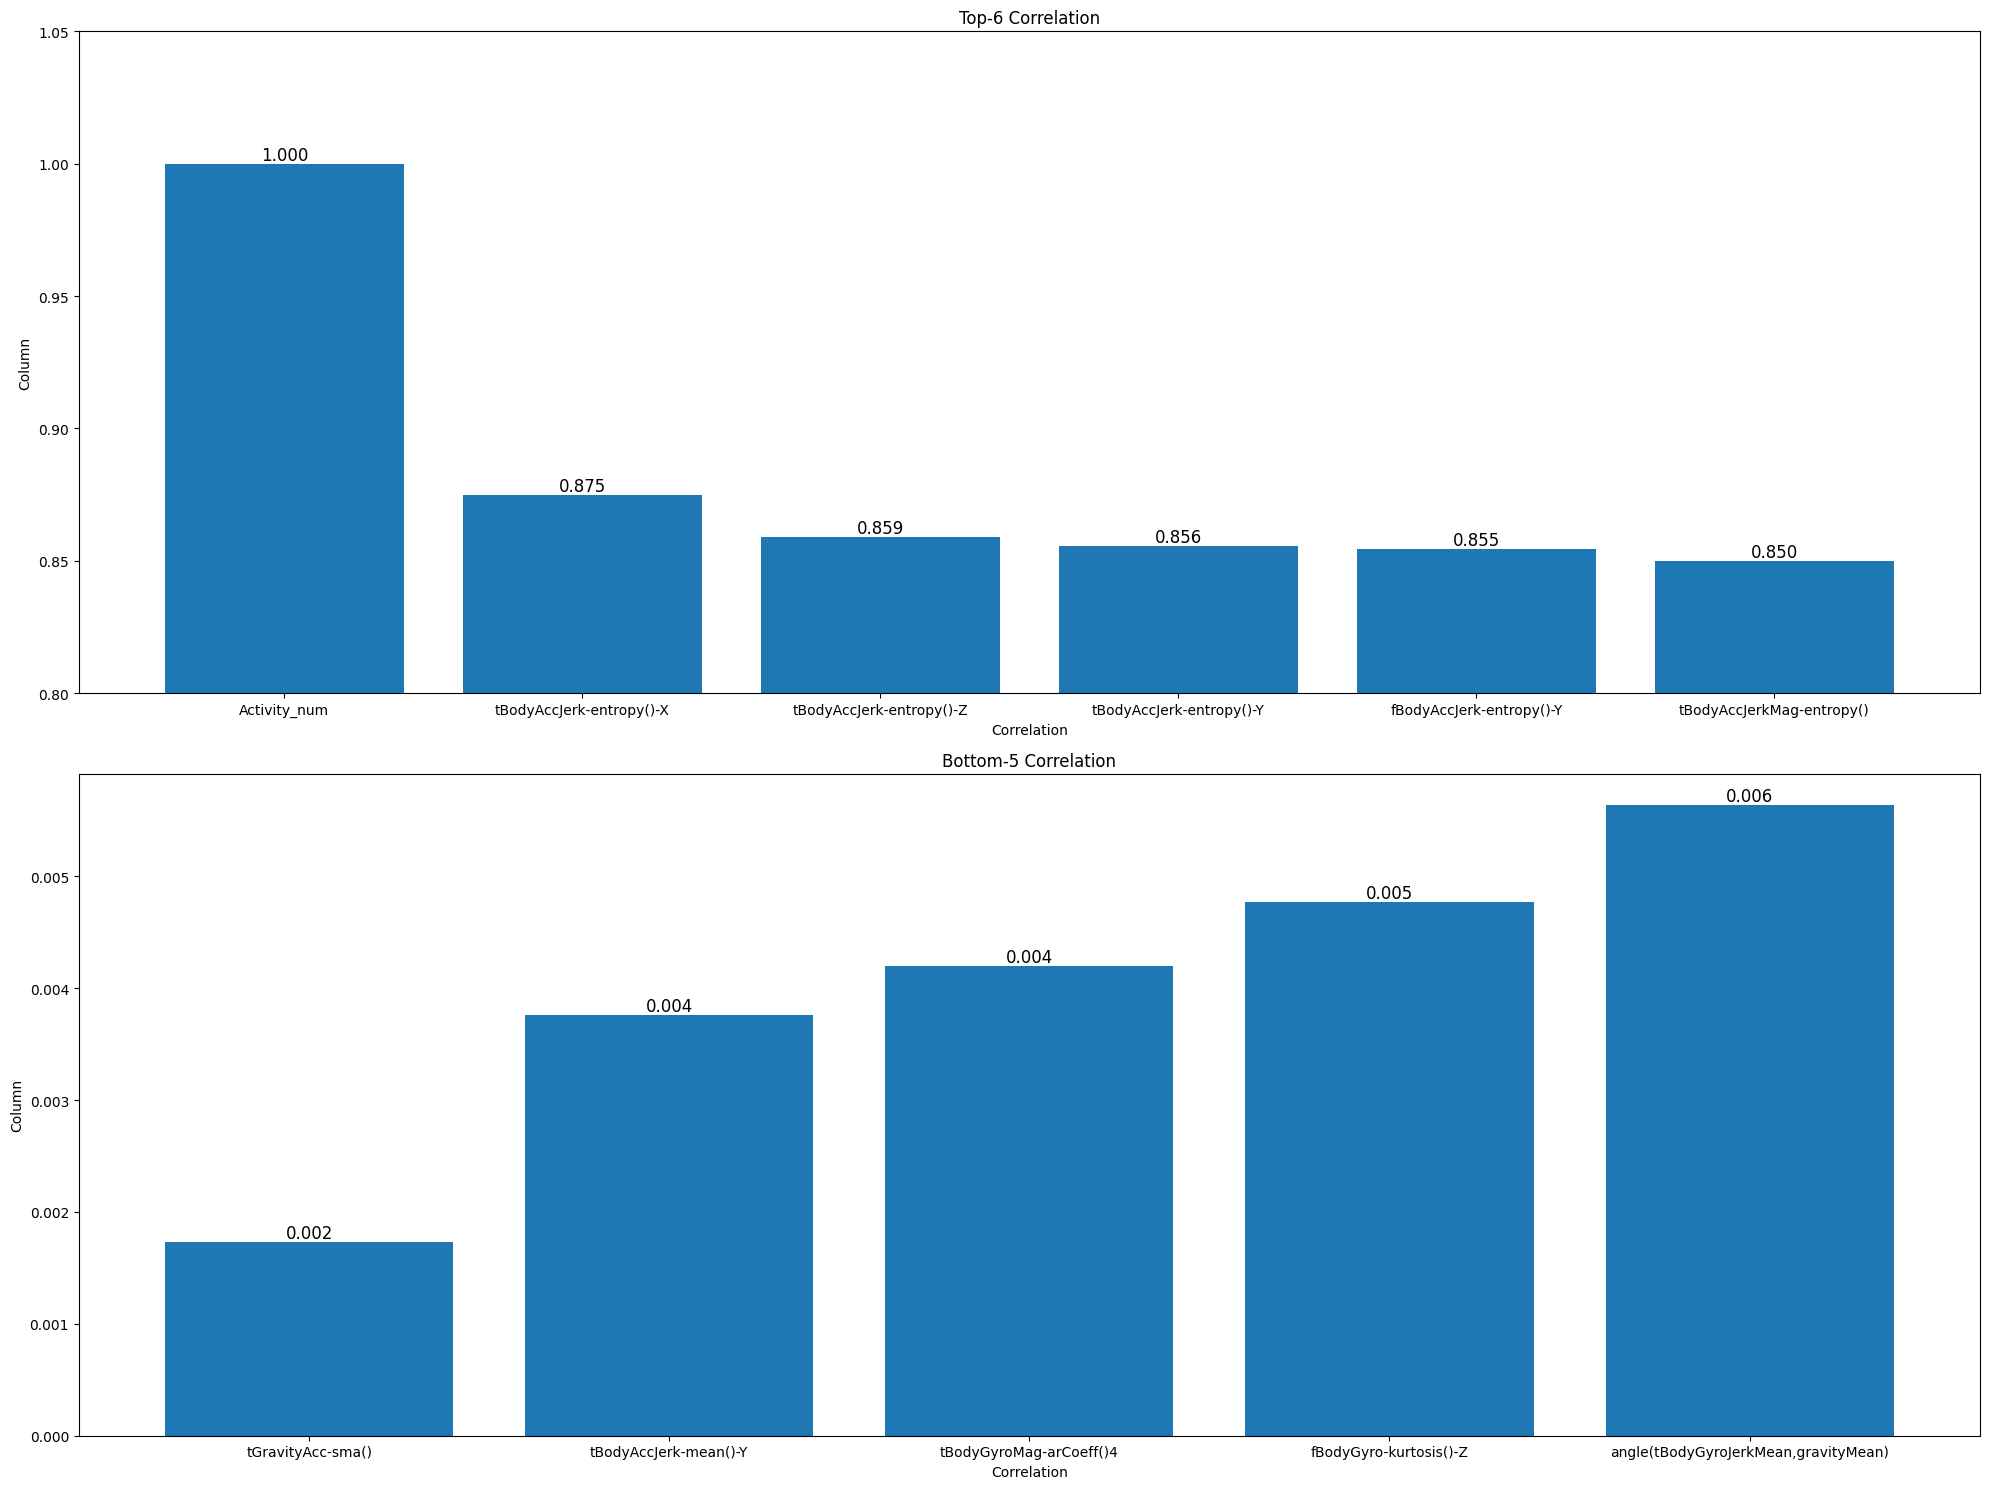

In [14]:
# 이변량 시각화 하기  (변수를 줄여서 해보는 것도 의미 있겠죠?)
# 변수를 줄인 상황에서의 특정 col과의 상관관계
# Top과 Bottom이므로 막대그래프 시각화로 단순 크기 비교 시각화하겠음
# 전체라면 heatmap이 기본이지만 특정 col을 기준으로 본다면 scatter 사용도 괜찮을 듯 함
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

# 상위 6개 Barplot
ax1.bar(top_6_corr.index, top_6_corr.values)
ax1.set_ylim(bottom=0.8)
ax1.set_ylabel('Column')
ax1.set_xlabel('Correlation')
ax1.set_title('Top-6 Correlation')
for i, (index, val) in enumerate(top_6_corr.items()):
    ax1.annotate(f"{val:.3f}", xy=(i, val), ha='center', va='bottom', fontsize=12)

# 하위 5개 Barplot
ax2.bar(bottom_5_corr.index, bottom_5_corr.values)
ax2.set_ylabel('Column')
ax2.set_xlabel('Correlation')
ax2.set_title('Bottom-5 Correlation')
for i, (index, val) in enumerate(bottom_5_corr.items()):
    ax2.annotate(f"{val:.3f}", xy=(i, val), ha='center', va='bottom', fontsize=12)

fig.tight_layout()
plt.show()


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

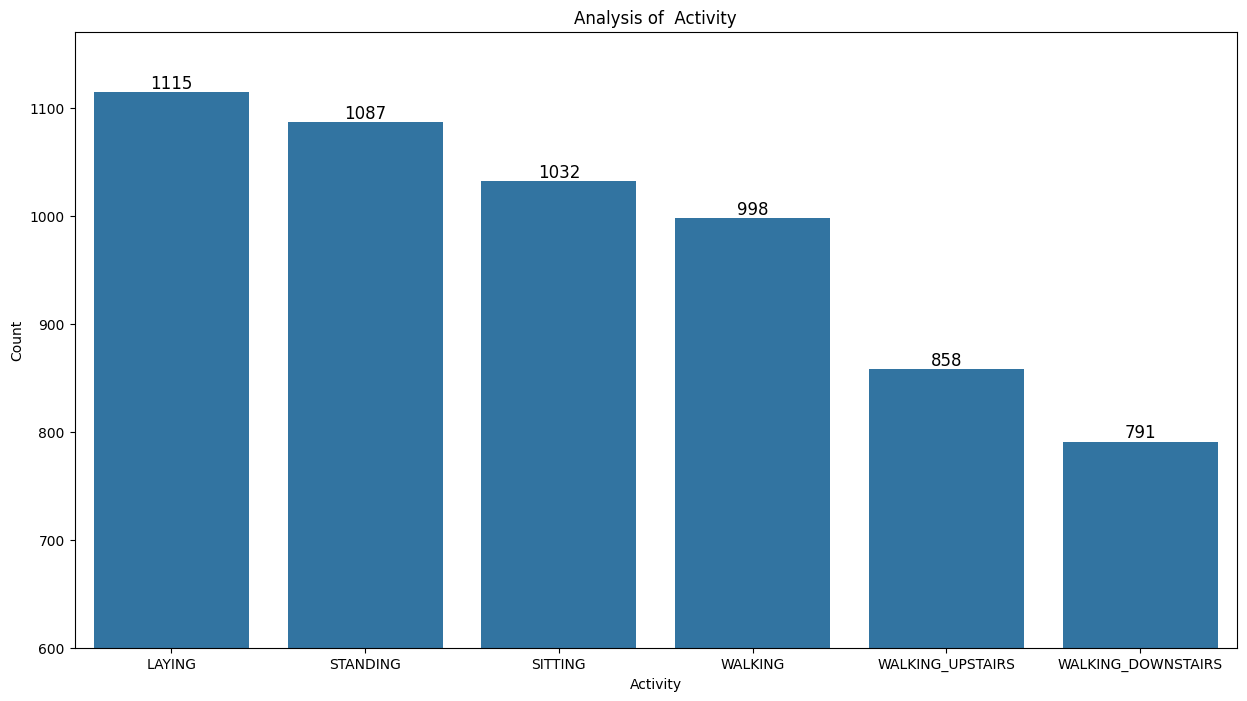

In [15]:
plt.figure(figsize=(15, 8))
sns.countplot(x='Activity', data=data, order = data['Activity'].value_counts().index)
for i, (target, count) in enumerate(zip(data['Activity'], data['Activity'].value_counts())):
    plt.annotate(f"{count}", xy=(i, count), ha='center', va='bottom', fontsize=12)
plt.ylim(bottom=600)
plt.title('Analysis of  Activity')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

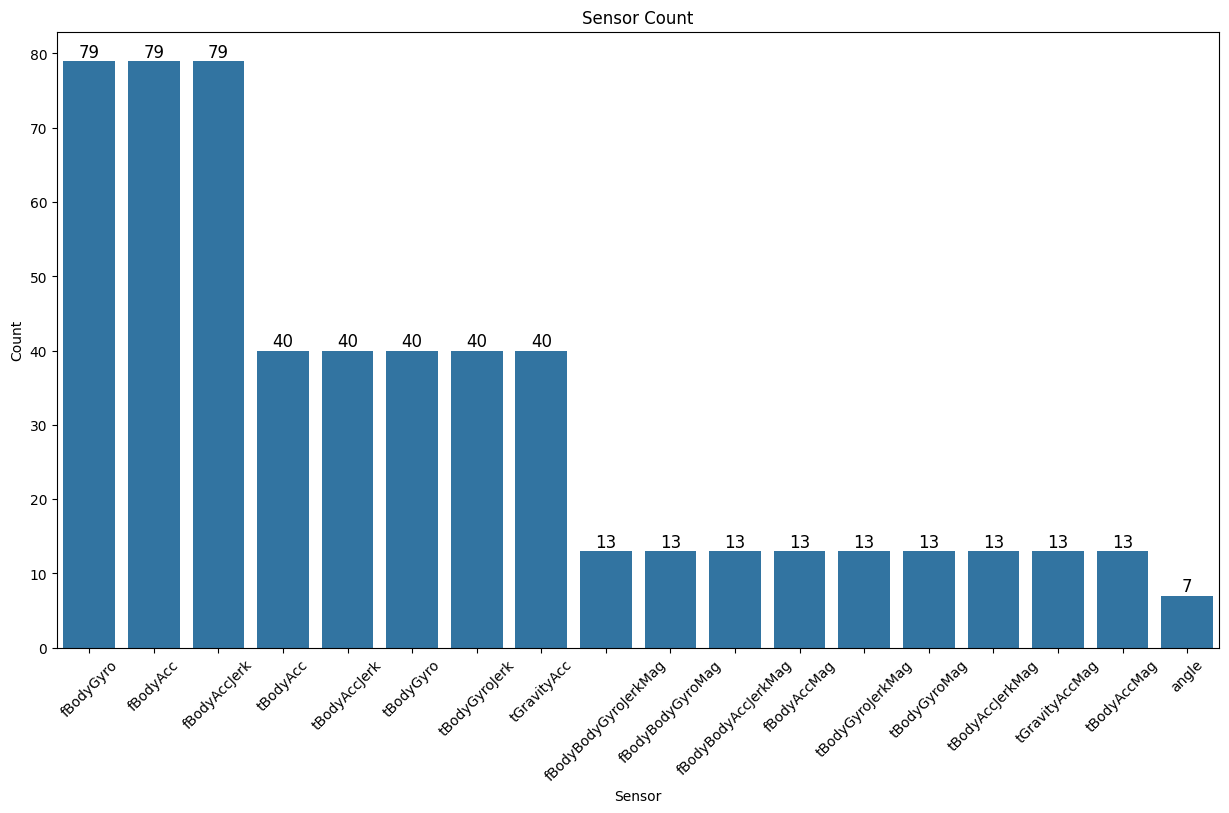

In [16]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
plt.figure(figsize=(15, 8))
sns.countplot(x='sensor', data=features, order = features['sensor'].value_counts().index)
for i, (sensor, count) in enumerate(zip(features['sensor'], features['sensor'].value_counts())):
    plt.annotate(f"{count}", xy=(i, count), ha='center', va='bottom', fontsize=12)
plt.title('Sensor Count')
plt.xlabel('Sensor')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()

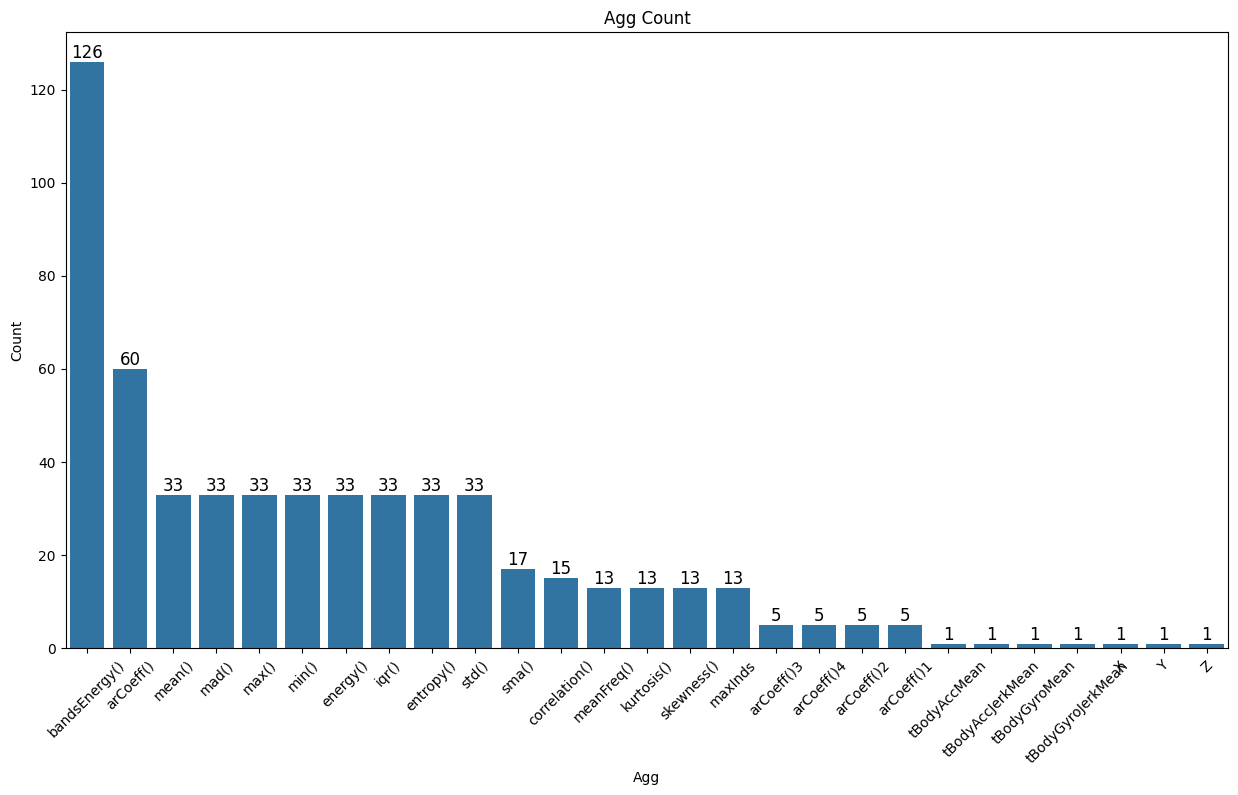

In [17]:
#센서 그룹 데이터의 'agg'변수의 값 확인
plt.figure(figsize=(15, 8))
sns.countplot(x='agg', data=features, order = features['agg'].value_counts().index)
for i, (aggr, count) in enumerate(zip(features['agg'], features['agg'].value_counts())):
    plt.annotate(f"{count}", xy=(i, count), ha='center', va='bottom', fontsize=12)
plt.title('Agg Count')
plt.xlabel('Agg')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()

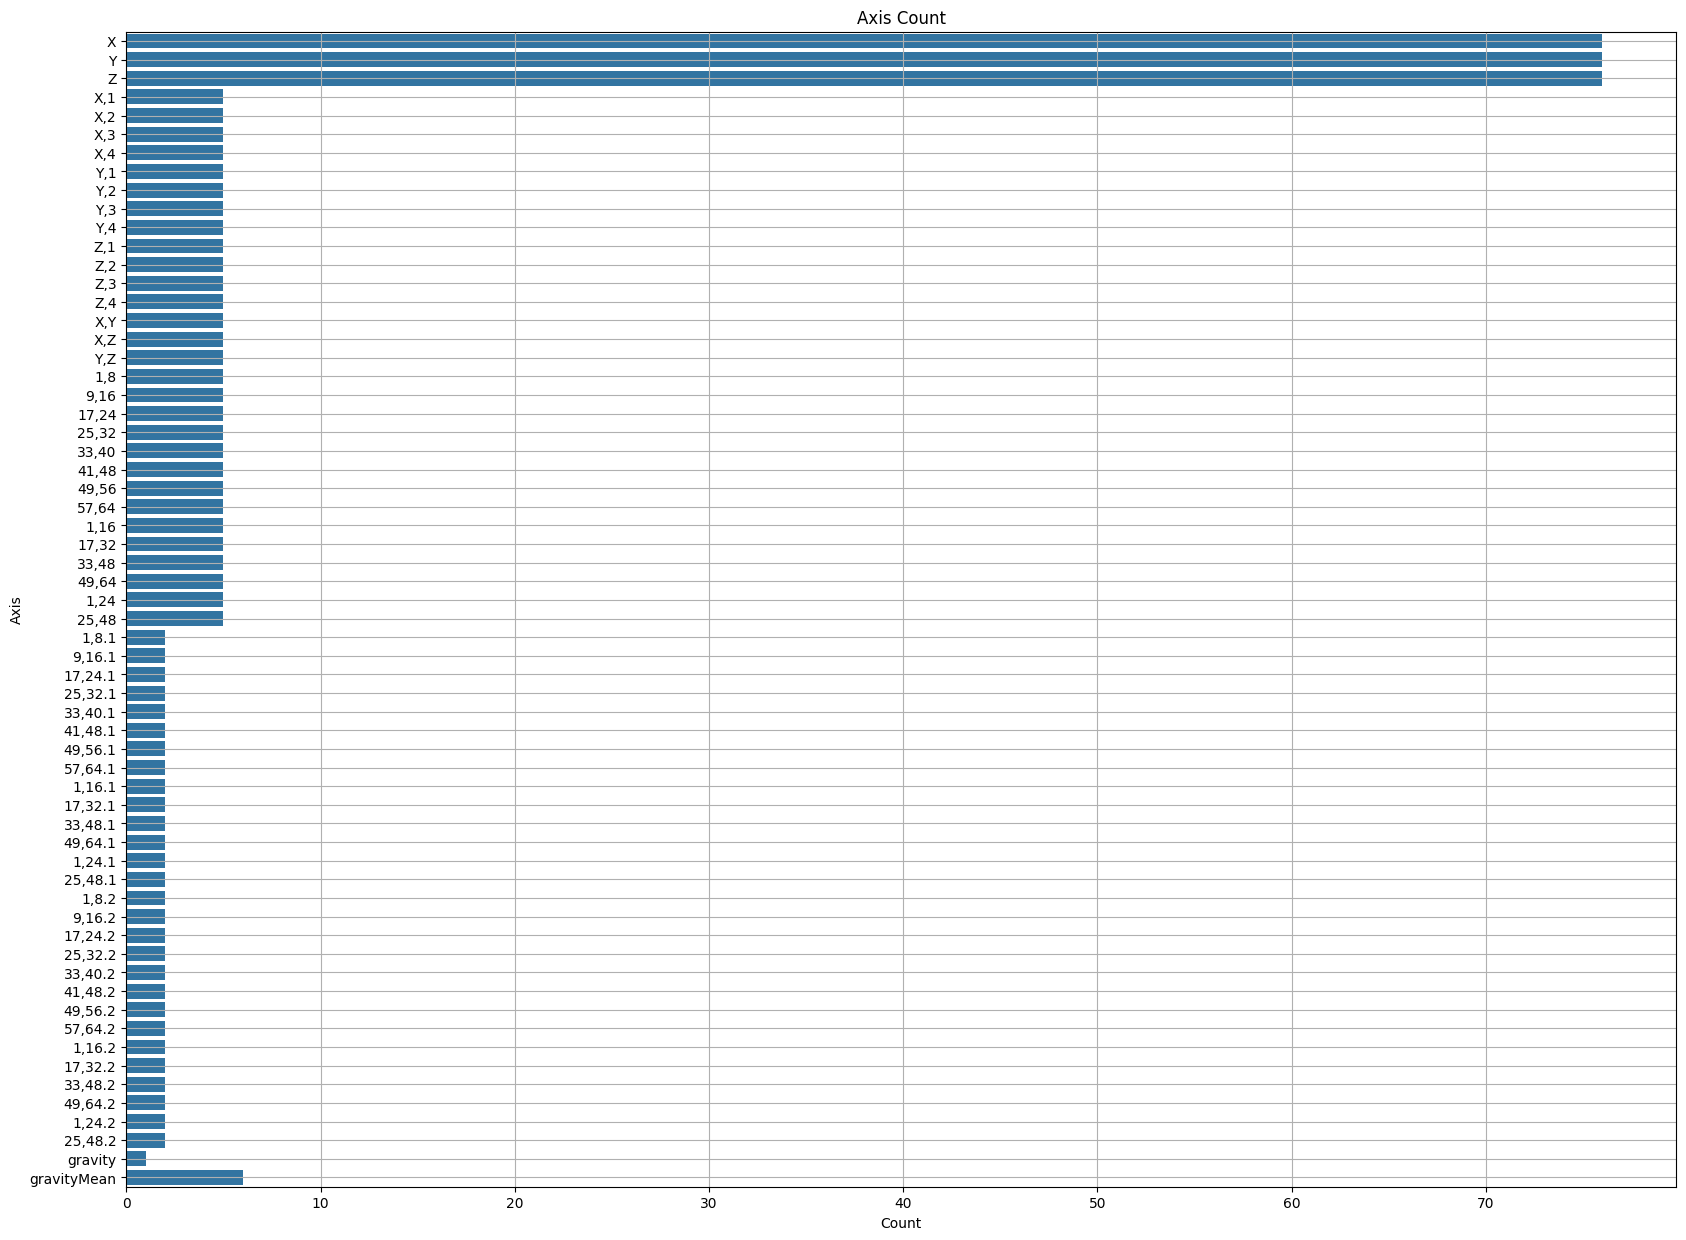

In [18]:
#센서 그룹 데이터의 'axis'변수의 값 확인
plt.figure(figsize=(20, 15))
sns.countplot(y='axis', data=features)
plt.title('Axis Count')
plt.ylabel('Axis')
plt.xlabel('Count')
plt.grid()
plt.show()

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다. 
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [19]:
# 데이터 분할을 위한 전처리
target = 'Activity'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3)

#### 2) 모델링

In [20]:
#생성
model = RandomForestClassifier()

#학습
model.fit(x_train, y_train)
pred = model.predict(x_val)

#평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

accuracy : 0.9949008498583569
[[321   0   0   0   0   0]
 [  0 333   5   0   0   0]
 [  0   2 299   0   0   0]
 [  0   0   0 302   0   0]
 [  0   0   0   1 245   1]
 [  0   0   0   0   0 256]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       321
           SITTING       0.99      0.99      0.99       338
          STANDING       0.98      0.99      0.99       301
           WALKING       1.00      1.00      1.00       302
WALKING_DOWNSTAIRS       1.00      0.99      1.00       247
  WALKING_UPSTAIRS       1.00      1.00      1.00       256

          accuracy                           0.99      1765
         macro avg       1.00      1.00      1.00      1765
      weighted avg       0.99      0.99      0.99      1765



#### 3) 변수 중요도 추출

In [21]:
# 변수 중요도 추출
# r0 = plot_feature_importance(model.feature_importances_, list(x_train), False)
# 그래프가 오히려 헷갈림
# 어차피 정렬되어 있는 표이기 때문에 표만 출력

r0 = plot_feature_importance(model.feature_importances_, list(x_train), True)
r0 = r0.rename(columns={'feature_importance': 'FI'})
r0

feature_name        FI
0                      Activity_num  0.072718
1               tGravityAcc-min()-X  0.035518
2              tGravityAcc-mean()-Y  0.030464
3            tGravityAcc-energy()-X  0.028058
4              angle(Y,gravityMean)  0.025874
..                              ...       ...
558    fBodyAcc-bandsEnergy()-25,48  0.000057
559              fBodyAcc-maxInds-Z  0.000049
560  fBodyAcc-bandsEnergy()-57,64.1  0.000047
561    fBodyAcc-bandsEnergy()-49,64  0.000044
562            fBodyAccJerk-min()-Y  0.000042

[563 rows x 2 columns]

#### 4) feature importance 데이터 가져오기
위 모델링을 통해 생성한 feature별 중요도 데이터를 제공해 드립니다. random forest 모델링이 너무 어렵다면, 해당 데이터를 활용해도 무방합니다.

In [22]:
#fi_analysis 데이터 불러오기
#data_path = "./fi_analysis.csv"
#fi_analysis = pd.read_csv(data_path)
#r0 = fi_analysis.filter(items=['feature_name','fi_all'])
#r0.rename(columns={'fi_all':'feature_importance'}, inplace=True) 
#r0.sort_values(by=['feature_importance'], axis=0, ascending=False)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

In [23]:
FI_top5 = r0.head()
FI_top5

feature_name        FI
0            Activity_num  0.072718
1     tGravityAcc-min()-X  0.035518
2    tGravityAcc-mean()-Y  0.030464
3  tGravityAcc-energy()-X  0.028058
4    angle(Y,gravityMean)  0.025874

In [24]:
FI_bottom5 = r0.tail(5)
FI_bottom5

feature_name        FI
558    fBodyAcc-bandsEnergy()-25,48  0.000057
559              fBodyAcc-maxInds-Z  0.000049
560  fBodyAcc-bandsEnergy()-57,64.1  0.000047
561    fBodyAcc-bandsEnergy()-49,64  0.000044
562            fBodyAccJerk-min()-Y  0.000042

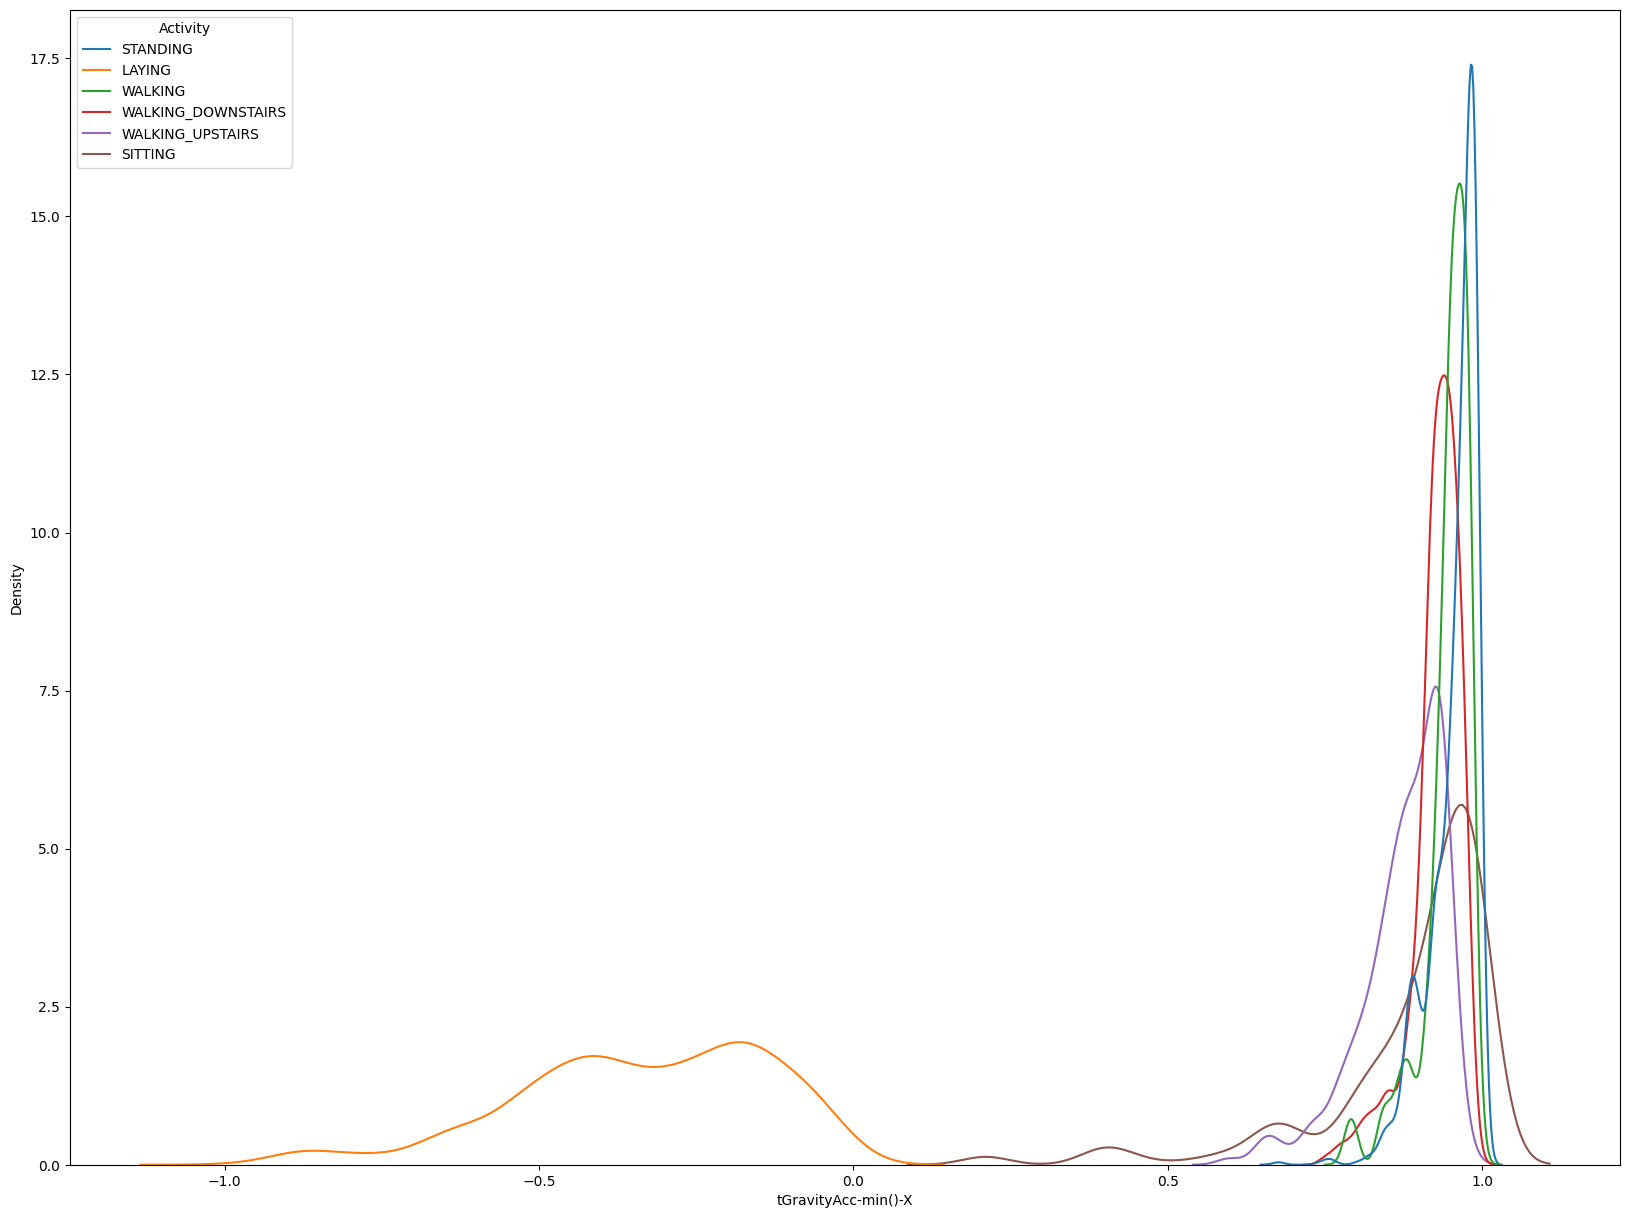

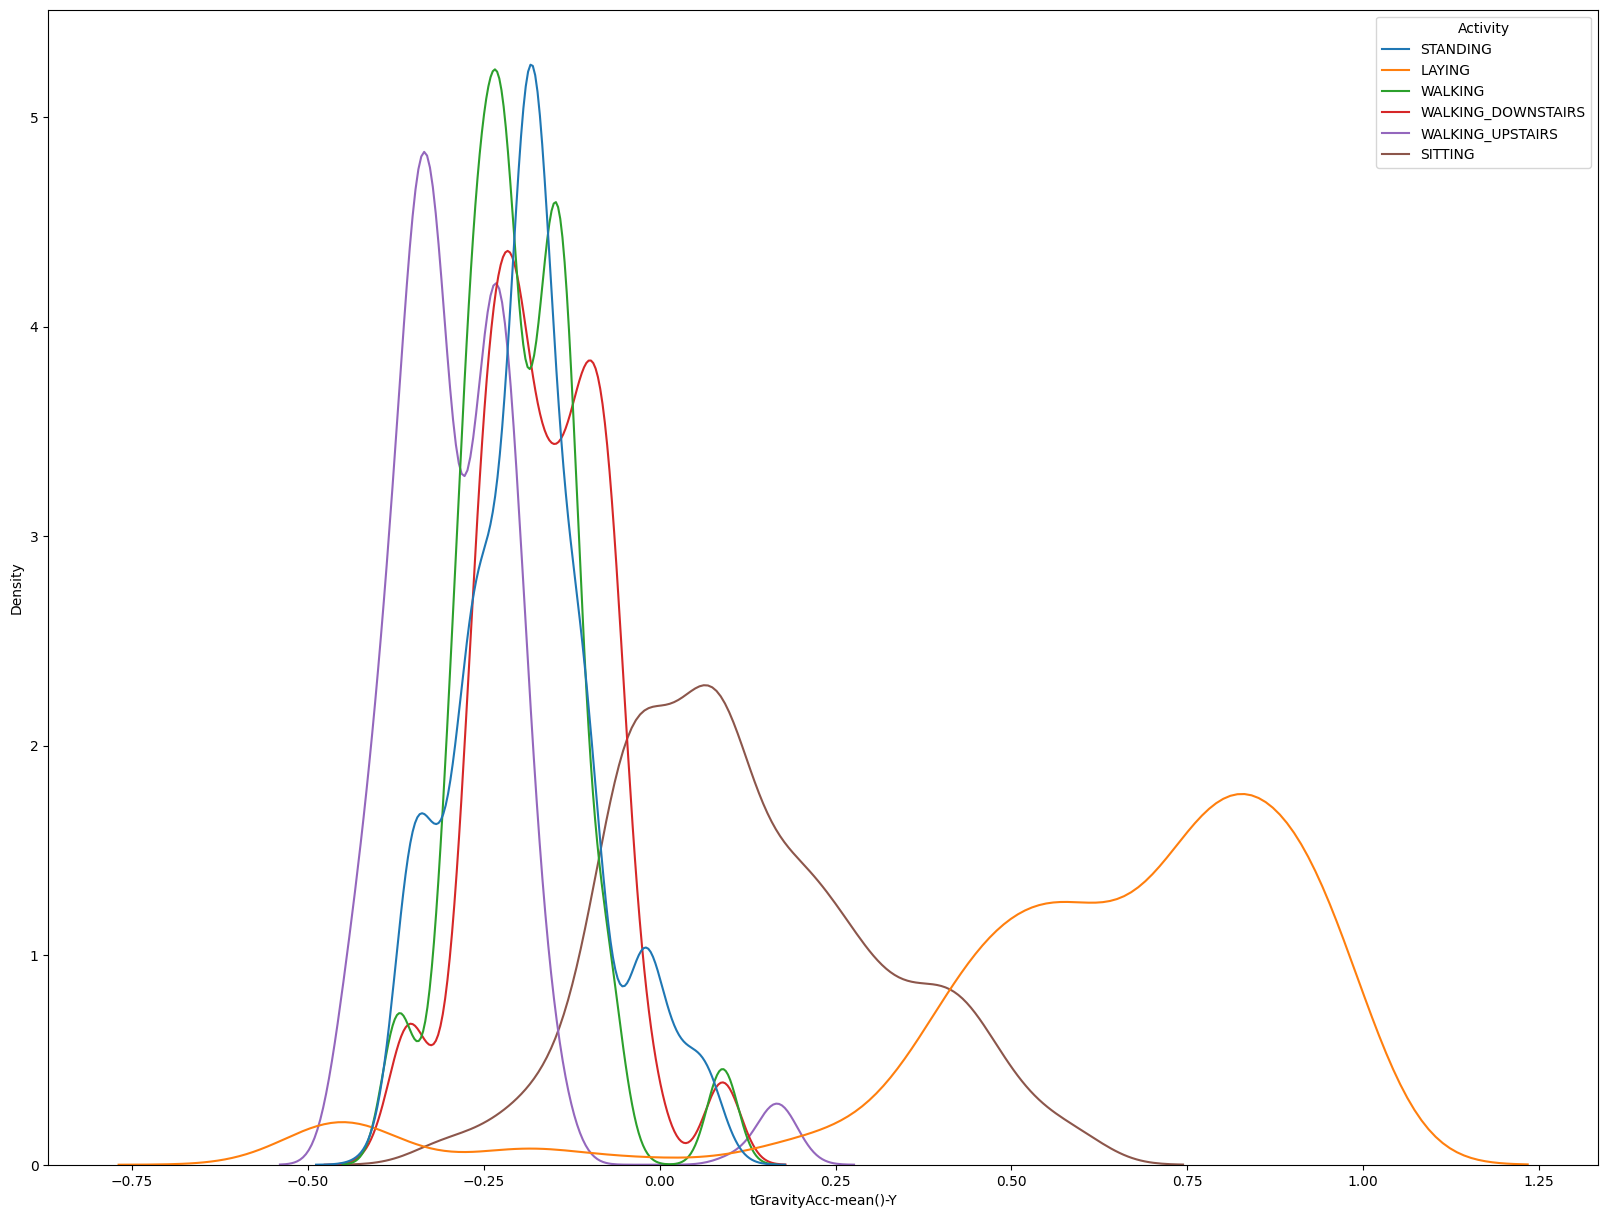

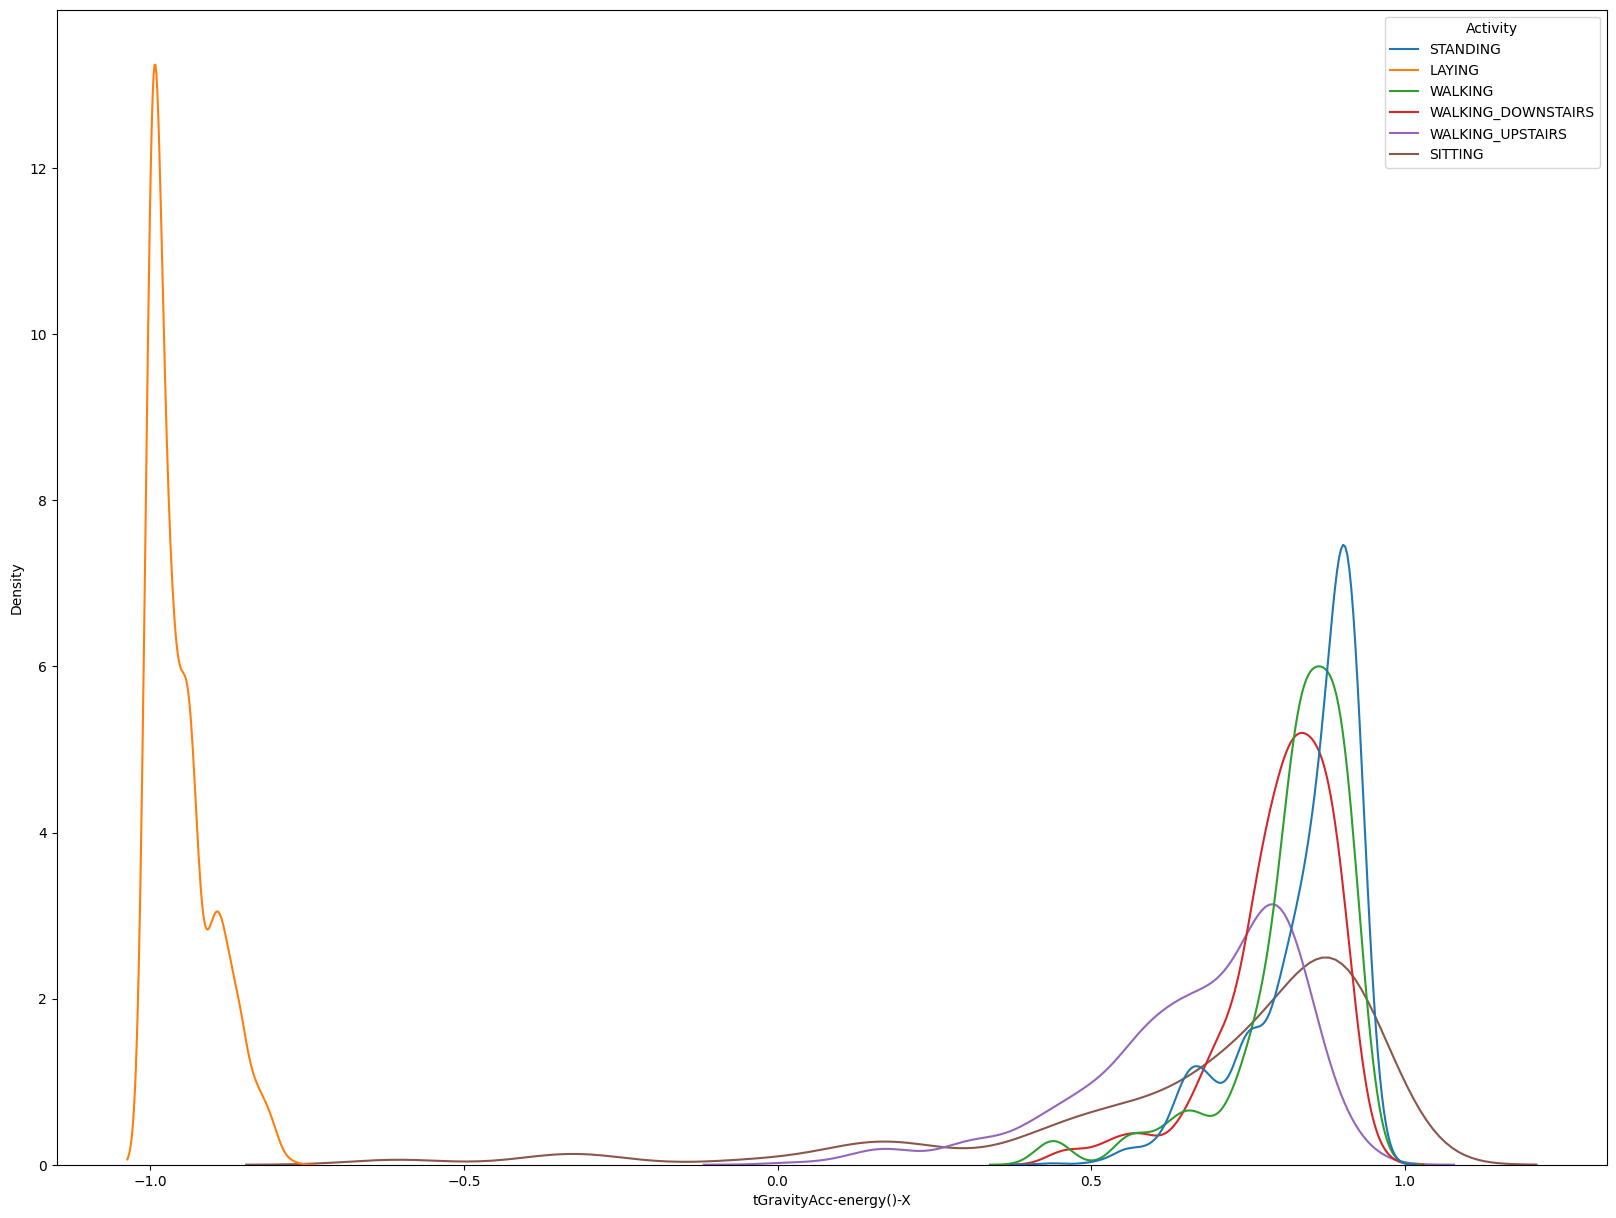

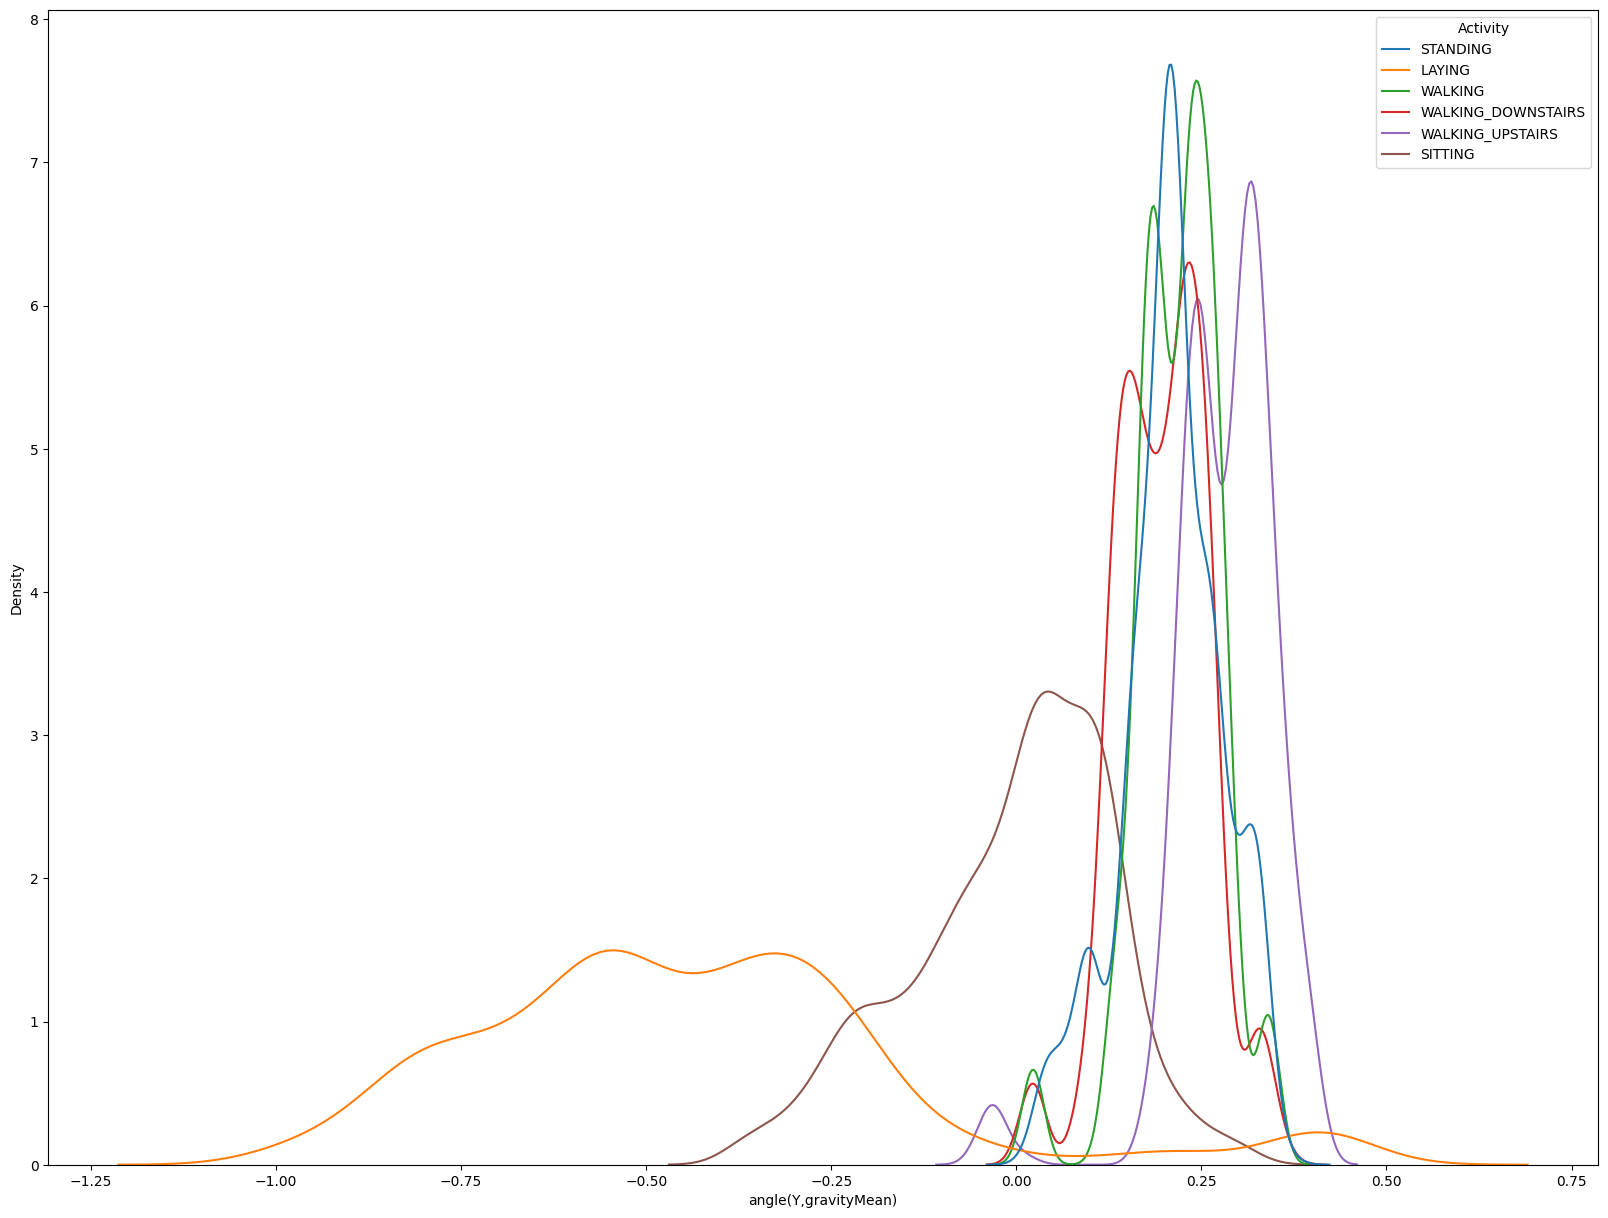

In [25]:
# Activity_num은 단순 mapping이므로 제외
for i in range(1, 5):
    var = FI_top5['feature_name'][i]
    plt.figure(figsize = (20,15))
    sns.kdeplot(x=var, data=data, hue=target, common_norm=False)

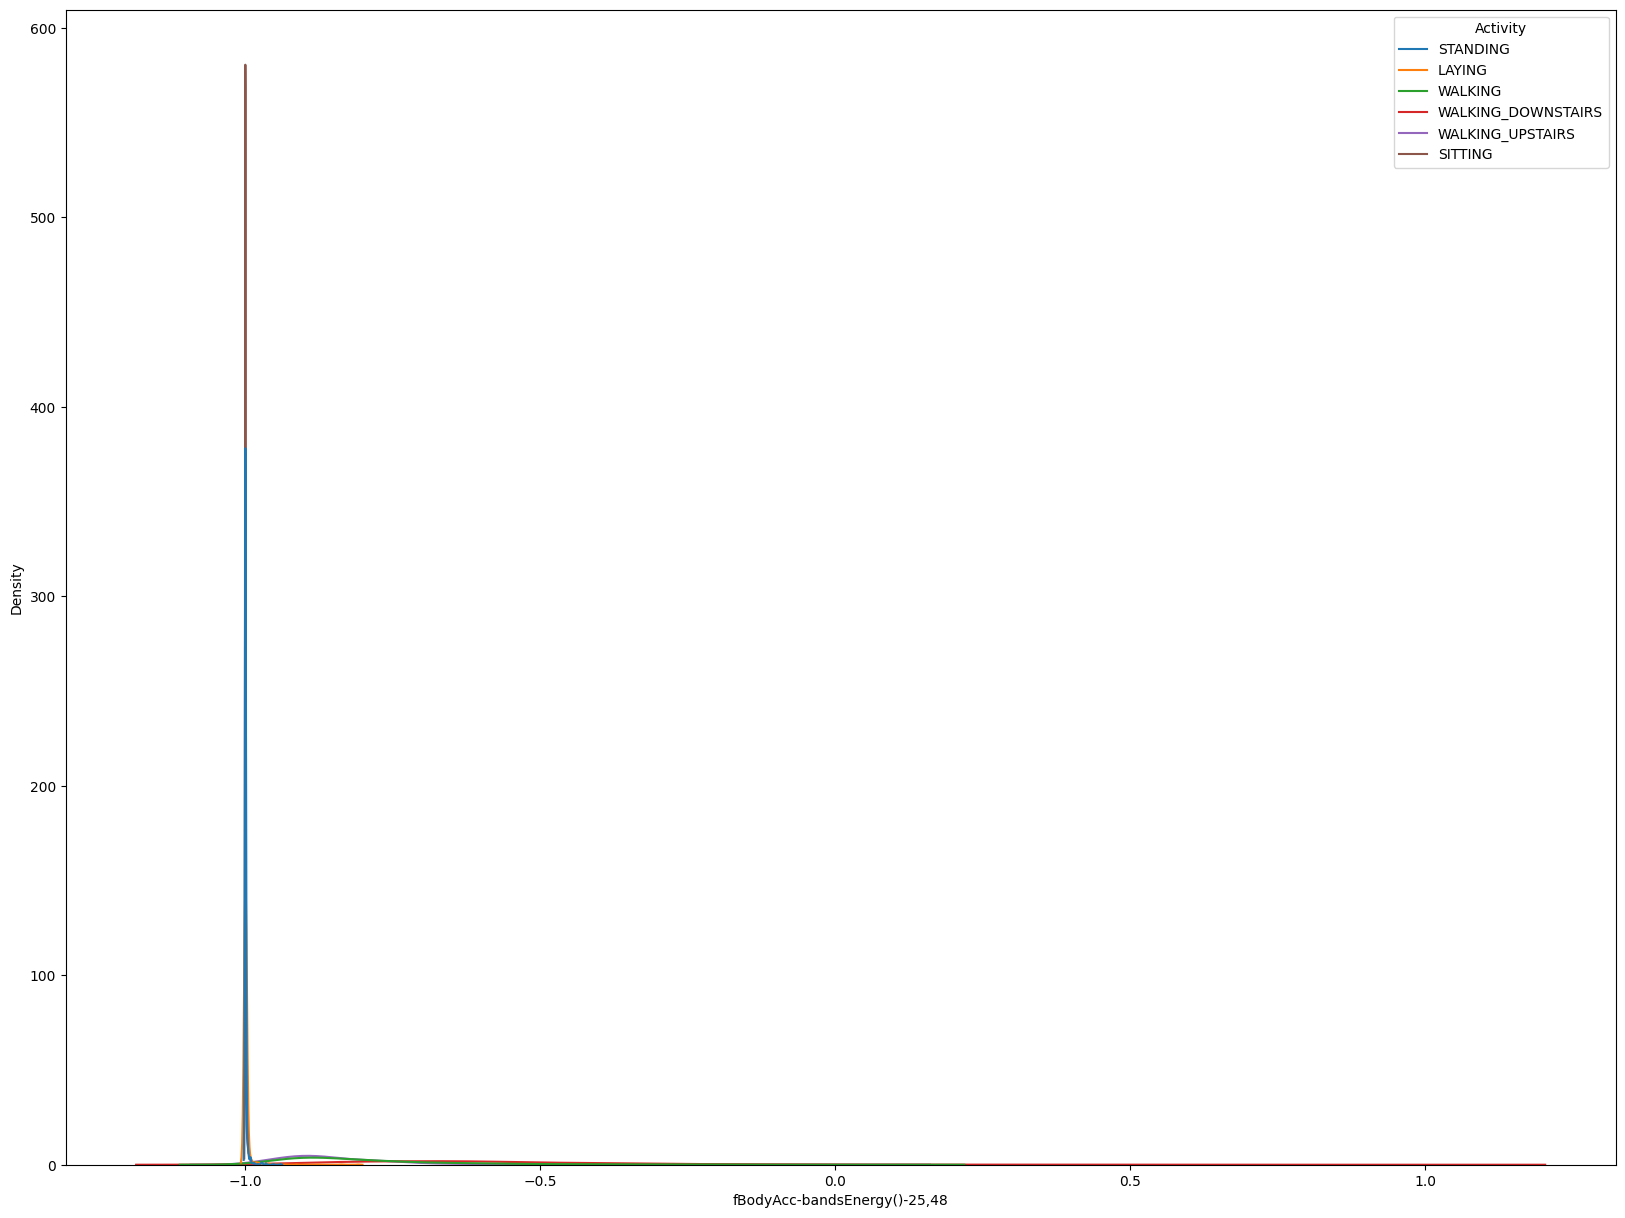

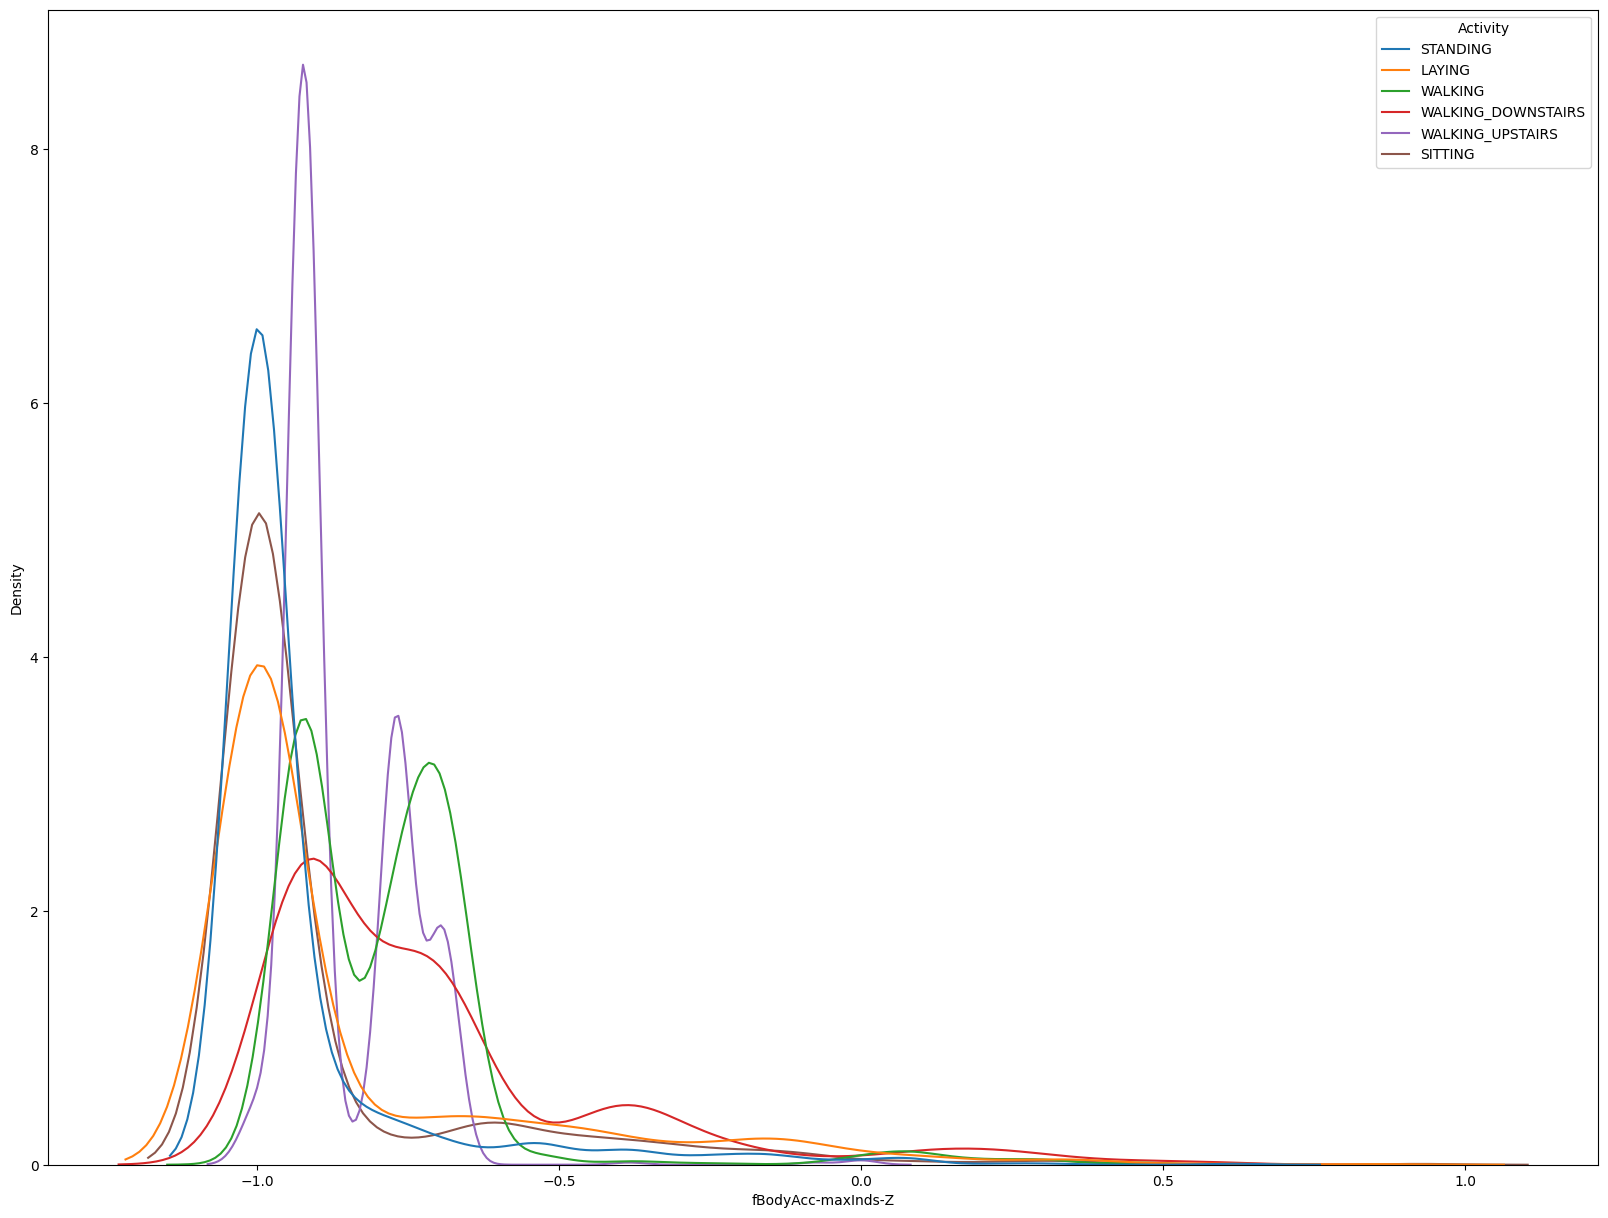

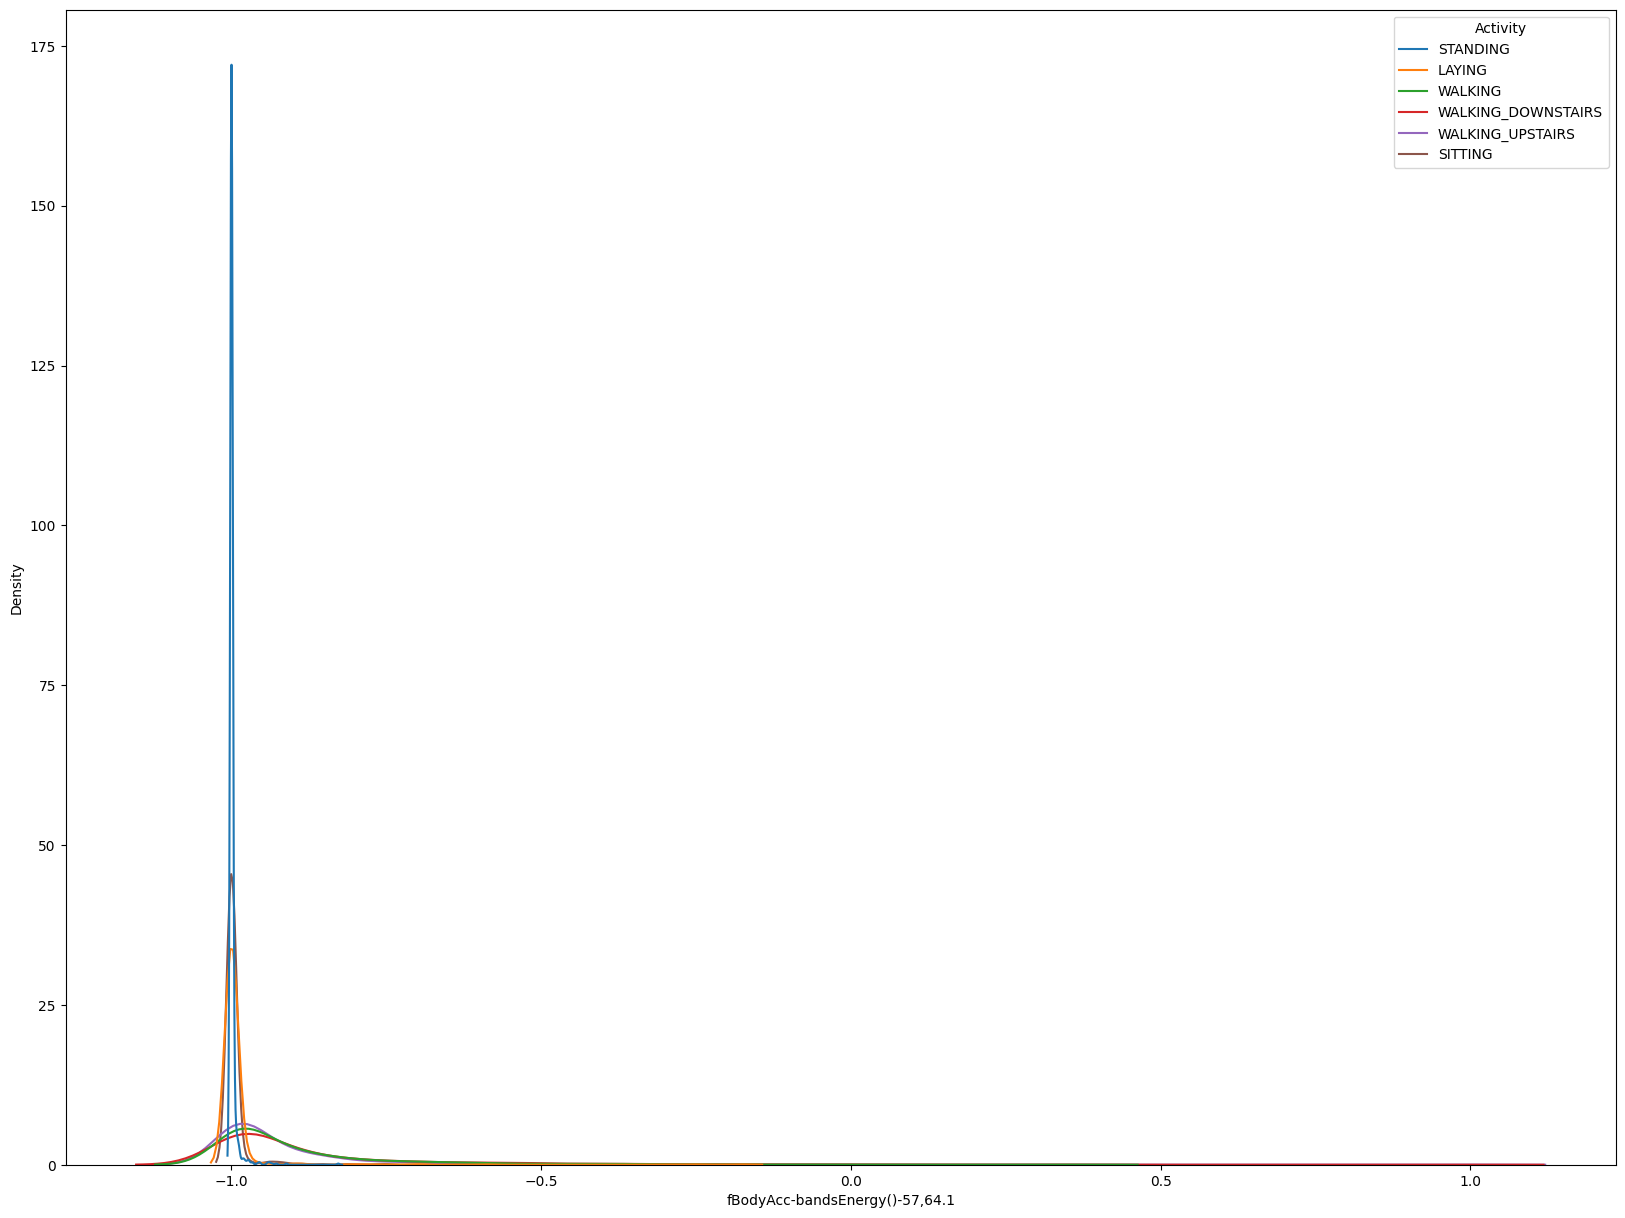

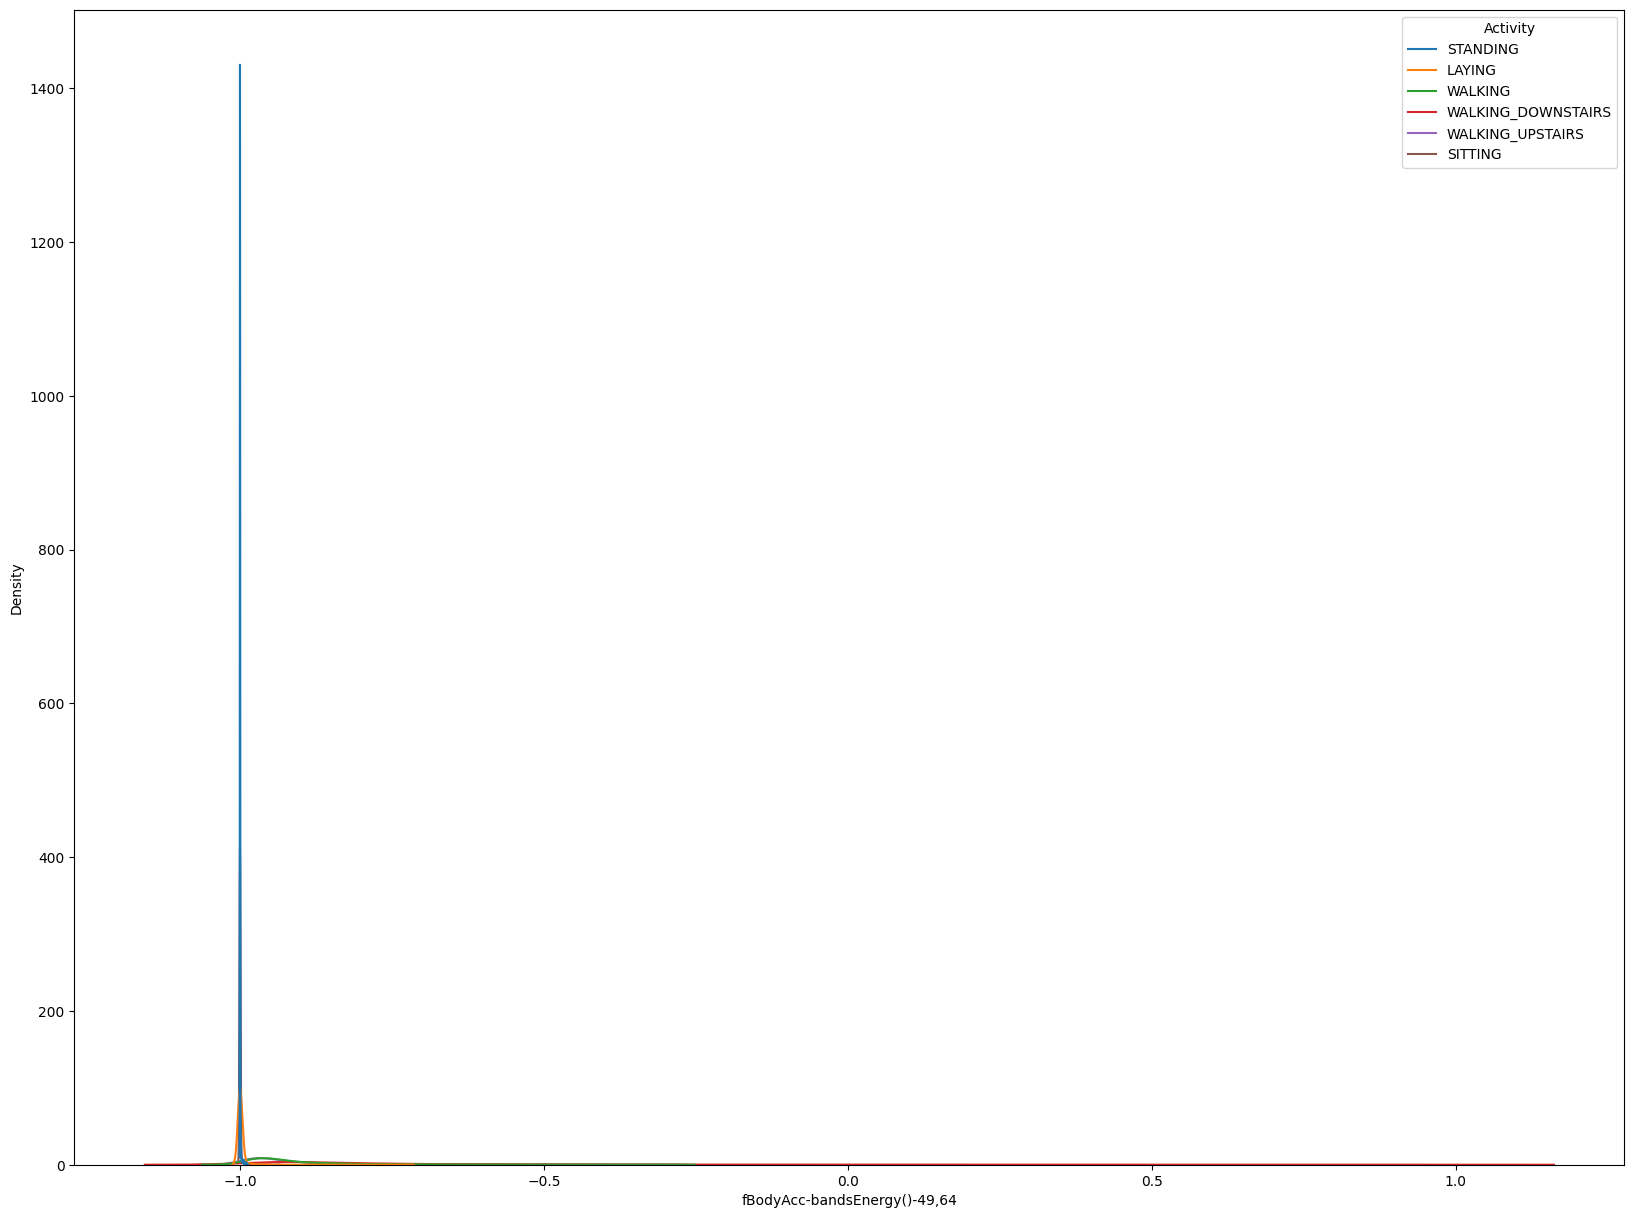

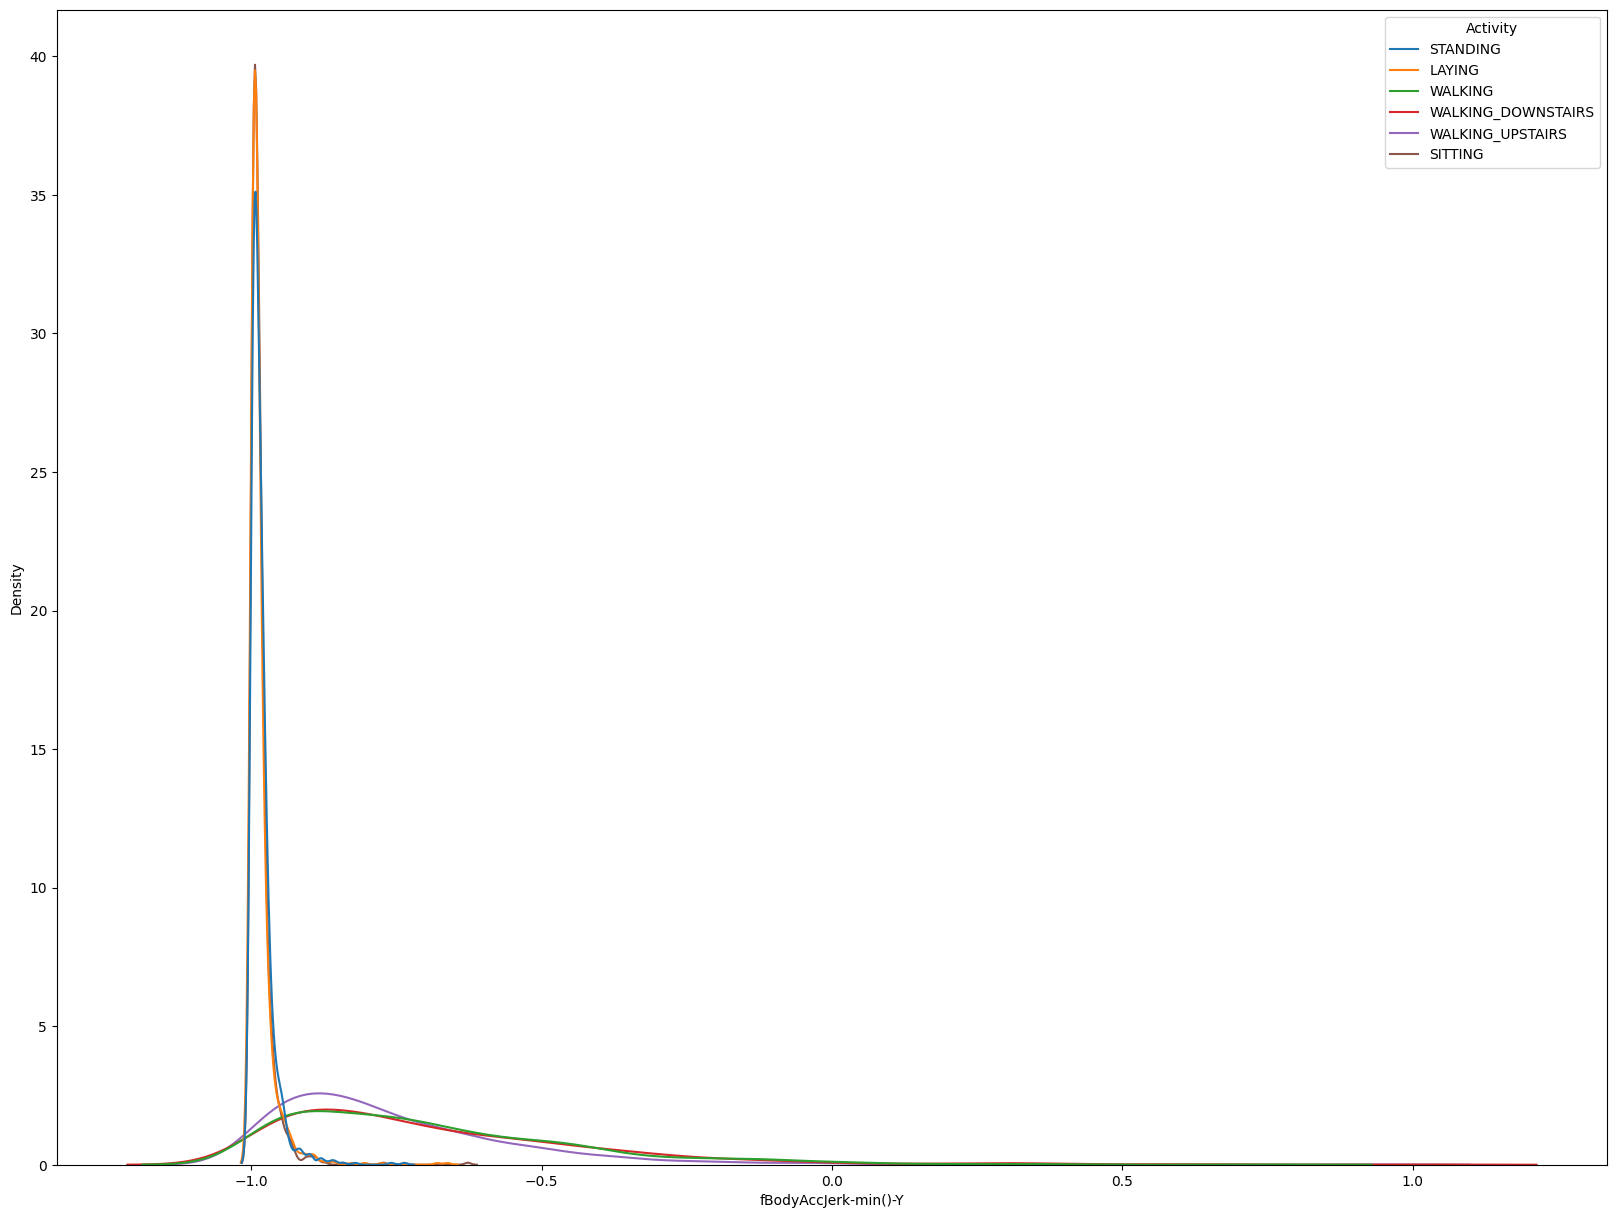

In [26]:
for i in range(558, 563):
    var = FI_bottom5['feature_name'][i]
    plt.figure(figsize = (20,15))
    sns.kdeplot(x=var, data=data, hue=target, common_norm=False)

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오. 


#### 1) 결과 merge

In [27]:
# outer join
df_merge = pd.merge(features, r0, on='feature_name', how='outer')
df_merge

sensor     agg axis                     feature_name        FI
0    tBodyAcc  mean()    X                tBodyAcc-mean()-X  0.000104
1    tBodyAcc  mean()    Y                tBodyAcc-mean()-Y  0.000345
2    tBodyAcc  mean()    Z                tBodyAcc-mean()-Z  0.000099
3    tBodyAcc   std()    X                 tBodyAcc-std()-X  0.003936
4    tBodyAcc   std()    Y                 tBodyAcc-std()-Y  0.000644
..        ...     ...  ...                              ...       ...
586       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-57,64.1  0.000174
587       NaN     NaN  NaN   fBodyGyro-bandsEnergy()-1,24.1  0.000157
588       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-49,56.1  0.000146
589       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-41,48.1  0.000127
590       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-33,48.1  0.000123

[591 rows x 5 columns]

#### 2) sensor 별 중요도

<Figure size 3000x3000 with 0 Axes>

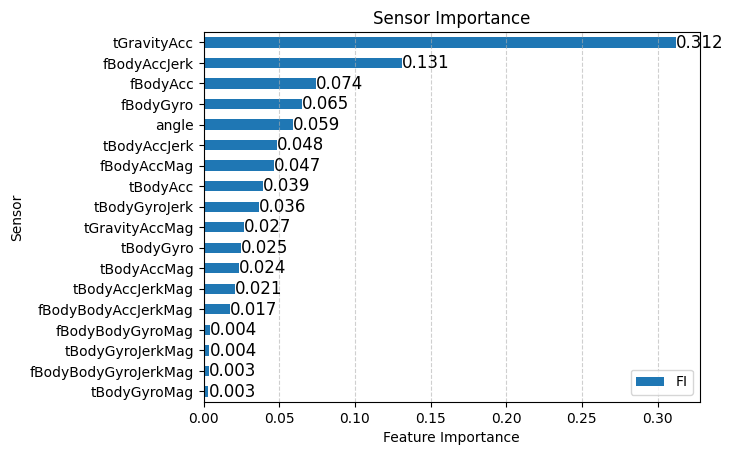

In [28]:
sensor_importance = df_merge.groupby('sensor')[['FI']].sum().sort_values('FI')

plt.figure(figsize=(30, 30))
sensor_importance.plot.barh()

for i, (index, value) in enumerate(sensor_importance.iterrows()):
    importance_value = value['FI']
    plt.annotate(f"{importance_value:.3f}", xy=(importance_value, i), ha='left', va='center', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.xlabel('Feature Importance')
plt.ylabel('Sensor')
plt.title('Sensor Importance')
plt.legend(loc='lower right')

plt.show()

#### 3) sensor + agg 별 중요도

<Figure size 3000x3000 with 0 Axes>

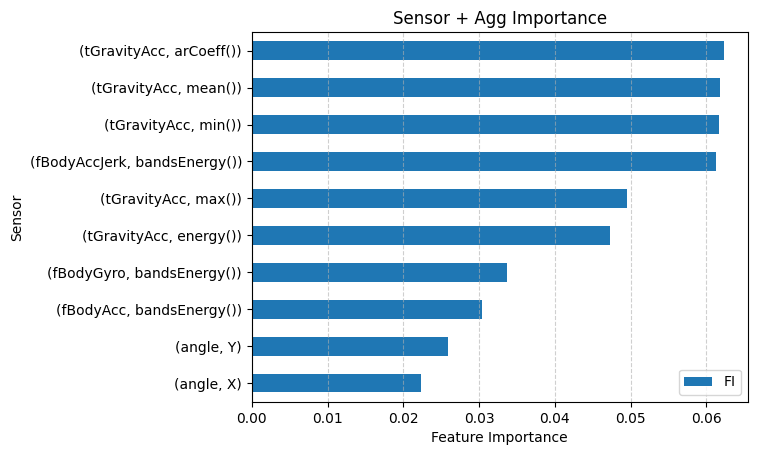

In [29]:
importance = df_merge.groupby(['sensor', 'agg'])[['FI']].sum().sort_values('FI')

plt.figure(figsize=(30, 30))
importance.tail(10).plot.barh()

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.xlabel('Feature Importance')
plt.ylabel('Sensor')
plt.title('Sensor + Agg Importance')
plt.legend(loc='lower right')

plt.show()

#### 3-1) sensor 별, agg로 나눠서 분석하기


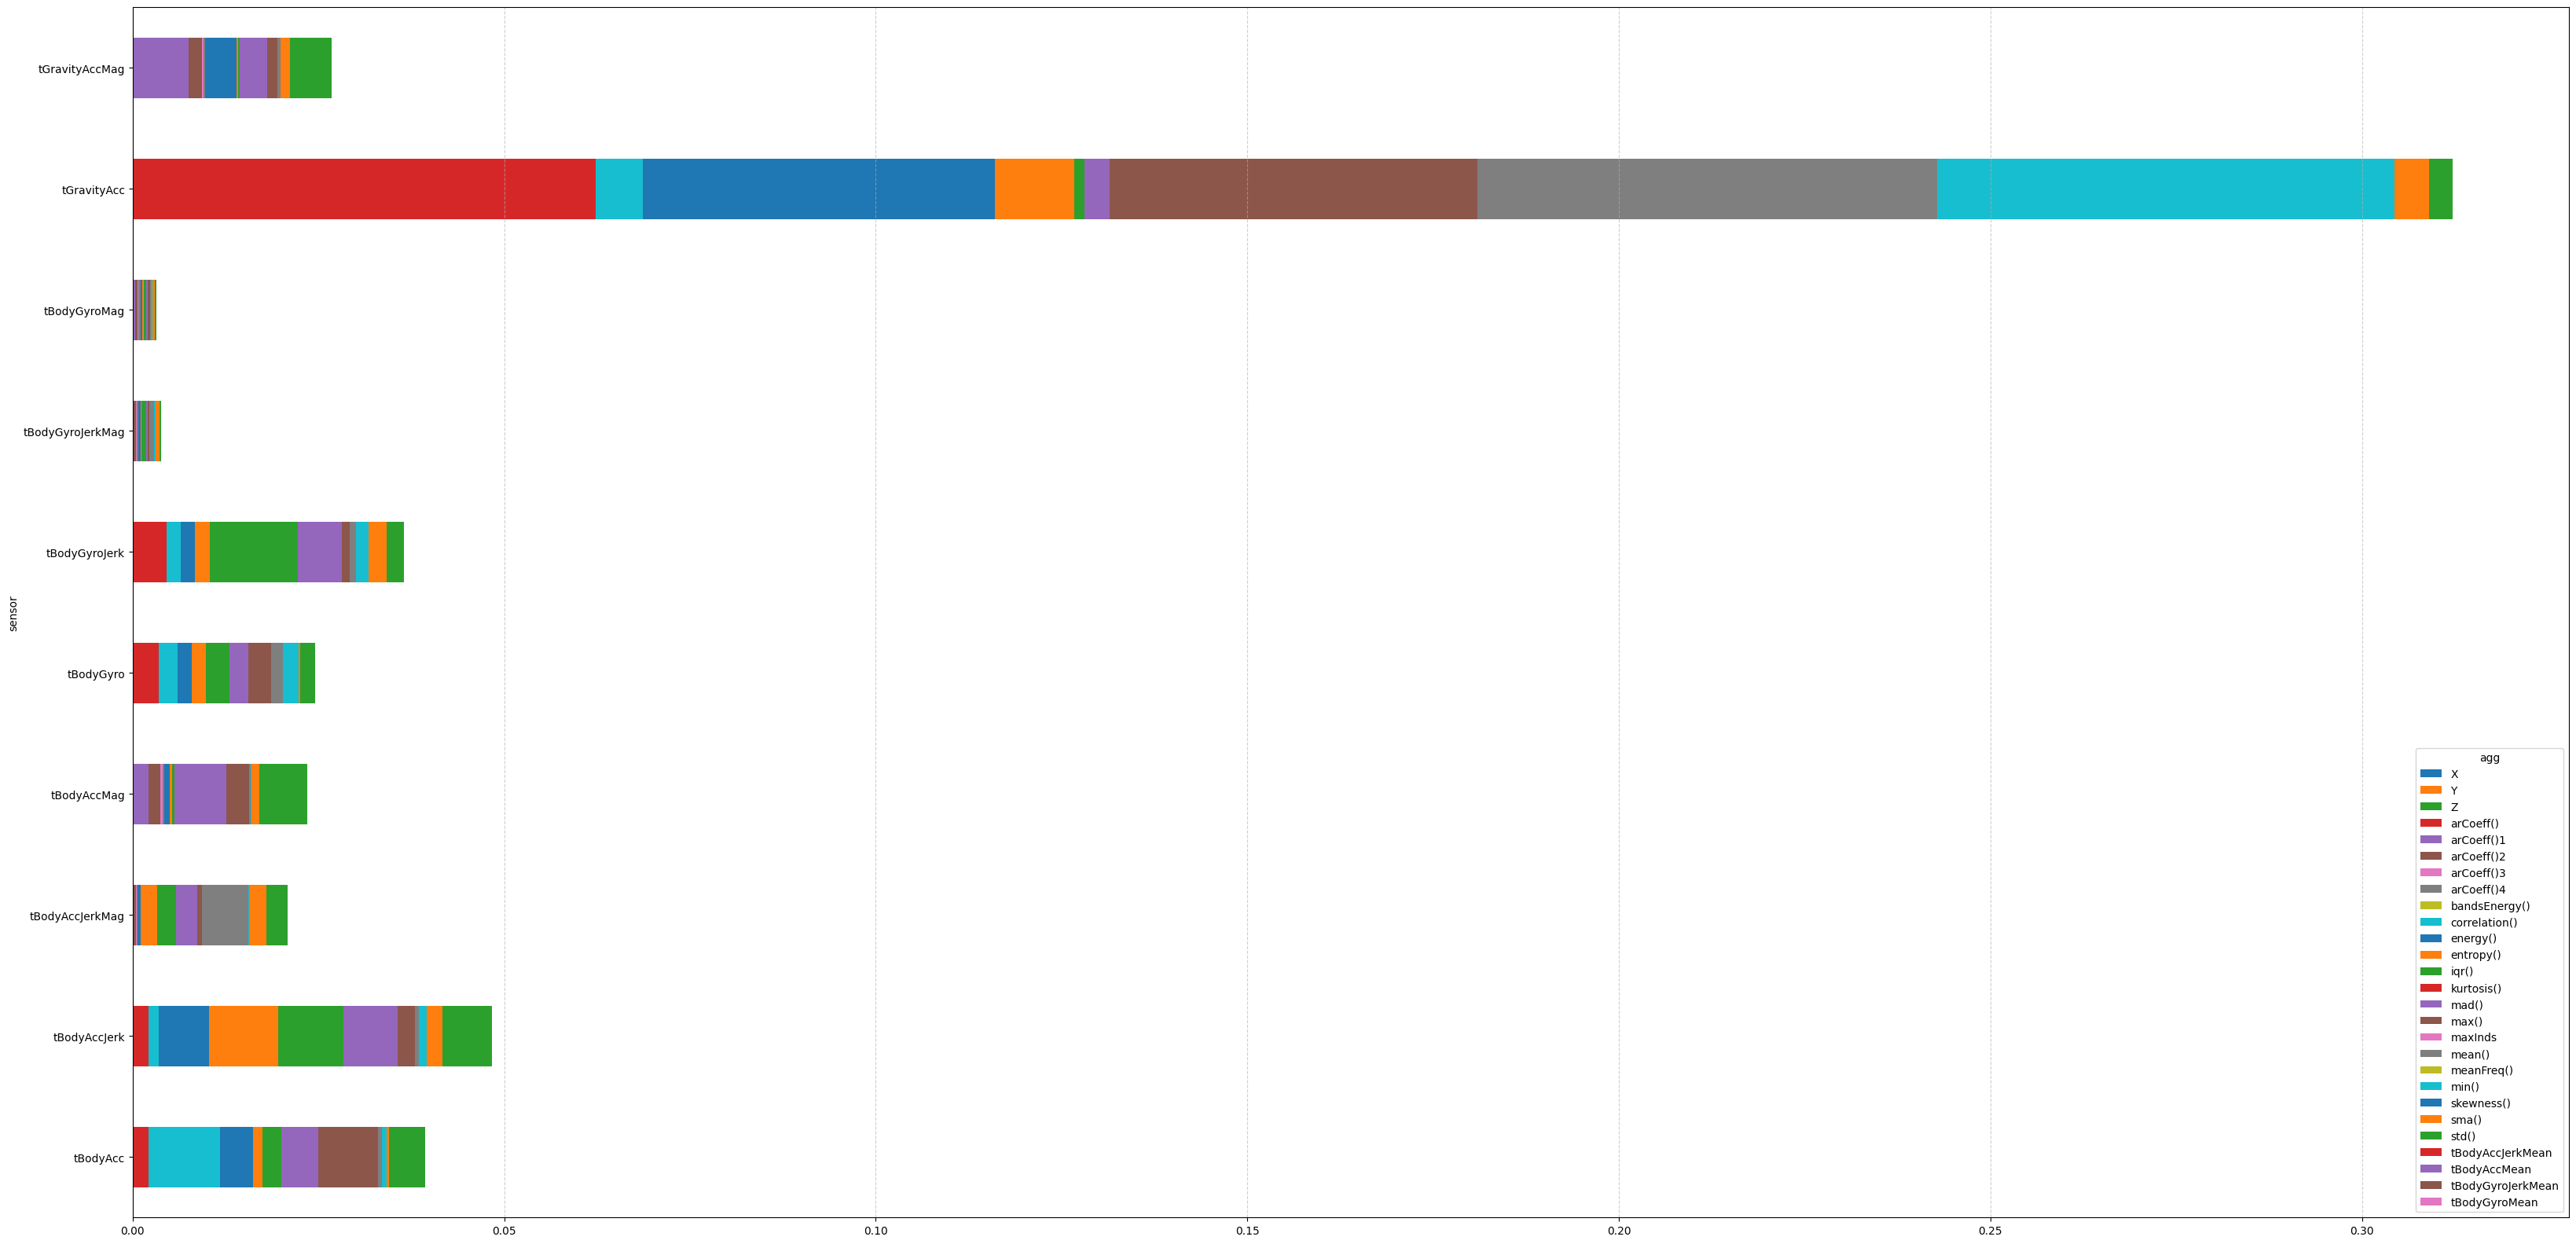

In [30]:
unstack_graph = df_merge.groupby(['sensor','agg'])['FI'].sum().unstack().tail(10)
unstack_graph.plot.barh(stacked=True, figsize=(40,20)) 
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가 (옵션)

In [31]:
is_dynamic = y.map({'STANDING':0, 'SITTING':0, 'LAYING':0, 
                  'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
is_dynamic

0       0
1       0
2       0
3       1
4       1
       ..
5876    0
5877    1
5878    0
5879    1
5880    0
Name: Activity, Length: 5881, dtype: int64

#### 2) 기본모델 생성 (옵션)

In [32]:
x_train, x_val, y_train, y_val = train_test_split(x, is_dynamic, test_size = .3)

In [33]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_val)

print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

accuracy : 1.0
[[963   0]
 [  0 802]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       963
           1       1.00      1.00      1.00       802

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 3) 변수중요도 상위 5개 분석 (옵션)

In [34]:
fi_dynamic = plot_feature_importance(model.feature_importances_, list(x_train), True)
fi_dynamic = fi_dynamic.rename(columns={'feature_importance': 'fi_dynamic'})
fi_dynamic.head(5)

feature_name  fi_dynamic
0             Activity_num    0.070118
1  fBodyAccJerk-energy()-X    0.049873
2    tBodyAccJerkMag-iqr()    0.049795
3     fBodyAccJerk-std()-X    0.039951
4     tBodyAccJerk-mad()-X    0.039951

#### 데이터 가져오기로 1), 2) 대체 가능

In [35]:
#fi_analysis 데이터 불러오기
#data_path = "./fi_analysis.csv"
#fi_analysis = pd.read_csv(data_path)
#r_dyn = fi_analysis.filter(items=['feature_name','fi_all'])
#r_dyn.rename(columns={'fi_dynamic':'feature_importance'}, inplace=True) 
#r_dyn.sort_values(by=['feature_importance'], axis=0, ascending=False)

#### 4) feature 그룹별 분석

In [36]:
df_merge = pd.merge(df_merge, fi_dynamic, on='feature_name', how='outer')
df_merge

sensor     agg axis                     feature_name        FI  \
0    tBodyAcc  mean()    X                tBodyAcc-mean()-X  0.000104   
1    tBodyAcc  mean()    Y                tBodyAcc-mean()-Y  0.000345   
2    tBodyAcc  mean()    Z                tBodyAcc-mean()-Z  0.000099   
3    tBodyAcc   std()    X                 tBodyAcc-std()-X  0.003936   
4    tBodyAcc   std()    Y                 tBodyAcc-std()-Y  0.000644   
..        ...     ...  ...                              ...       ...   
586       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-57,64.1  0.000174   
587       NaN     NaN  NaN   fBodyGyro-bandsEnergy()-1,24.1  0.000157   
588       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-49,56.1  0.000146   
589       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-41,48.1  0.000127   
590       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-33,48.1  0.000123   

     fi_dynamic  
0      0.000062  
1      0.000020  
2      0.000029  
3      0.000059  
4      0.000000  
..          ...  
586    0.000000  
587    0.000000  
588    0.000000  
589    0.000000  
590    0.000000  

[591 rows x 6 columns]

<Figure size 3000x3000 with 0 Axes>

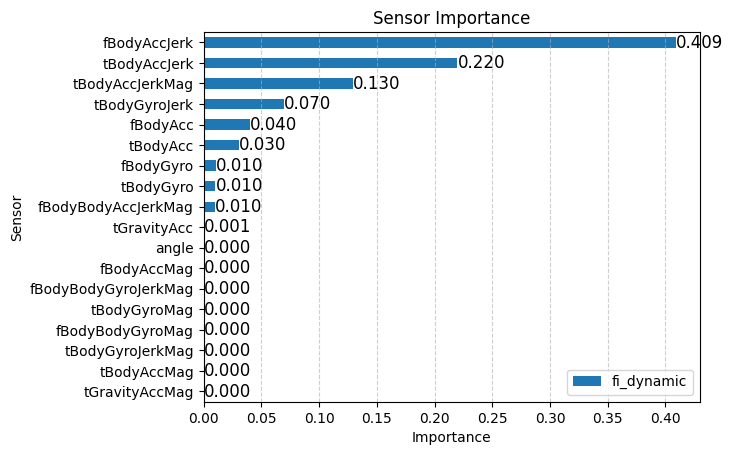

In [37]:
importance = df_merge.groupby('sensor')[['fi_dynamic']].sum().sort_values('fi_dynamic')
plt.figure(figsize=(30, 30))
importance.plot.barh()

for i, (index, value) in enumerate(importance.iterrows()):
    importance_value = value['fi_dynamic']
    plt.annotate(f"{importance_value:.3f}", xy=(importance_value, i), ha='left', va='center', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.xlabel('Importance')
plt.ylabel('Sensor')
plt.title('Sensor Importance')
plt.legend(loc='lower right')

plt.show()

<Figure size 3000x3000 with 0 Axes>

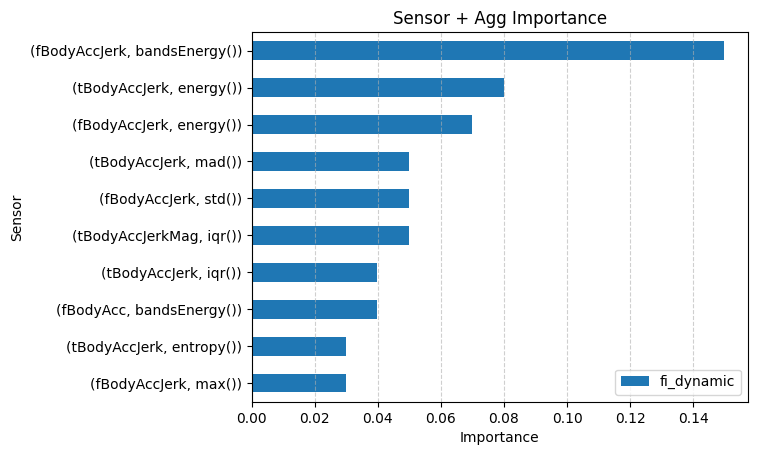

In [38]:
importance = df_merge.groupby(['sensor', 'agg'])[['fi_dynamic']].sum().sort_values('fi_dynamic')

plt.figure(figsize=(30, 30))
importance.tail(10).plot.barh()

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.xlabel('Importance')
plt.ylabel('Sensor')
plt.title('Sensor + Agg Importance')
plt.legend(loc='lower right')

plt.show()

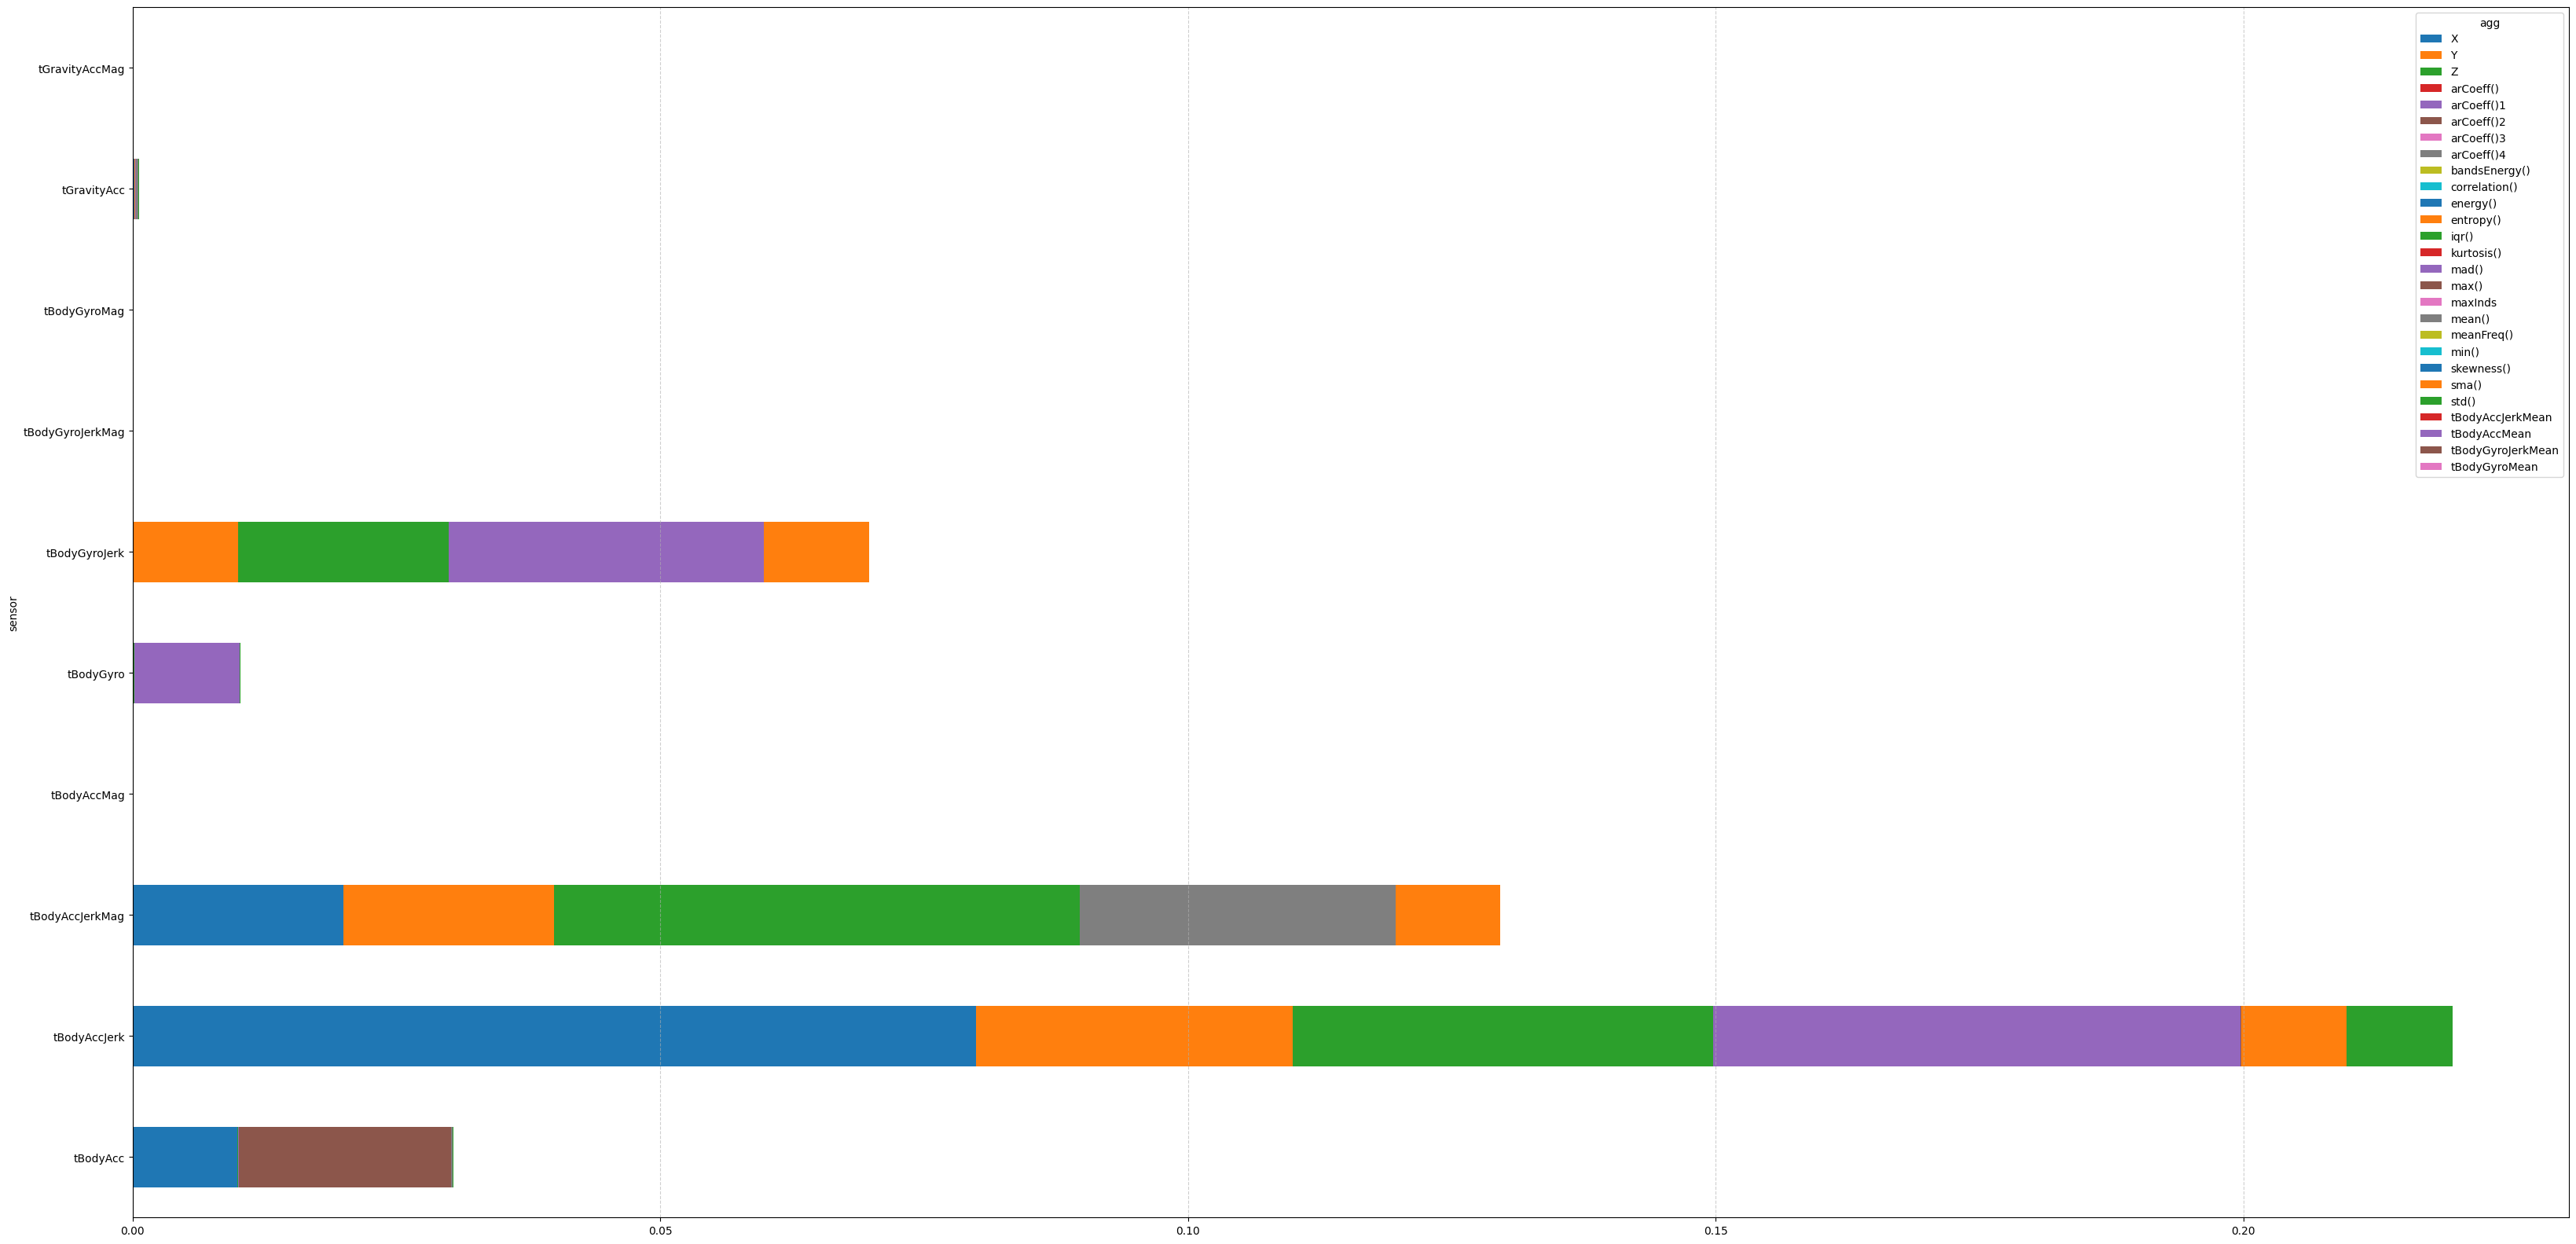

In [39]:
unstack_graph = df_merge.groupby(['sensor','agg'])['fi_dynamic'].sum().unstack().tail(10)
unstack_graph.plot.barh(stacked=True, figsize=(40,20)) 
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [40]:
x = data.drop([target, 'Activity_num'], axis=1)

In [41]:
def analyze_activity(x, y, activity, df=df_merge):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

    model = RandomForestClassifier()
    model.fit(x_train, y_train)

    pred = model.predict(x_val)

    print('=' * 60)
    print(f"** Evaluation for {activity} Activity**")
    print('accuracy :', accuracy_score(y_val, pred))
    print('=' * 60)
    print(confusion_matrix(y_val, pred))
    print('=' * 60)
    print(classification_report(y_val, pred))
    print('=' * 60)

    fi = plot_feature_importance(model.feature_importances_, list(x_train), True)
    fi = fi.rename(columns={'feature_importance': f'fi_{activity}'})
    print(f"** Feature Importance for {activity} Activity (Top 5)**")
    print(fi.head(5))
    print('=' * 60)

    for i in range(5):
        var = fi['feature_name'][i]
        plt.figure(figsize = (10,8))
        sns.kdeplot(x=var, data=data, hue=target, common_norm=False)

    print(f'** DataFrame (Top 5) **')
    df = pd.merge(df_merge, fi, on='feature_name', how='outer')
    print(df.head())

    return fi, df

In [42]:
def plot_FI(df_merge, activity, figsize=(30, 20)):

    importance = df_merge.groupby('sensor')[[activity]].sum().sort_values(activity).head(10)
    plt.figure(figsize=figsize)
    importance.plot.barh()
    plt.xlabel('Importance')
    plt.ylabel('Sensor')
    plt.title('Sensor Importance (Top 10)')
    plt.legend(title='Activity', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    importance = df_merge.groupby(['sensor', 'agg'])[[activity]].sum().sort_values(activity).tail(10)
    plt.figure(figsize=figsize)
    importance.plot.barh(stacked=False)
    plt.xlabel('Importance')
    plt.ylabel('Sensor + Aggregation')
    plt.title('Sensor + Aggregation Importance (Top 10)')
    plt.legend(title='Activity', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    unstack_graph = df_merge.groupby(['sensor','agg'])[[activity]].sum().unstack().tail(10)
    plt.figure(figsize=figsize)
    unstack_graph.plot.barh(stacked=True)
    plt.xlabel('Importance')
    plt.ylabel('Sensor + Aggregation')
    plt.title('Stacked Feature Importance (Top 10 Sensors)')
    plt.legend(title='Activity', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


** Evaluation for standing Activity**
accuracy : 0.9886685552407932
[[1434   11]
 [   9  311]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1445
           1       0.97      0.97      0.97       320

    accuracy                           0.99      1765
   macro avg       0.98      0.98      0.98      1765
weighted avg       0.99      0.99      0.99      1765

** Feature Importance for standing Activity (Top 5)**
           feature_name  fi_standing
0   tGravityAcc-max()-Y     0.083670
1  angle(Y,gravityMean)     0.052896
2  tGravityAcc-mean()-Y     0.044853
3   tGravityAcc-min()-Y     0.042360
4  angle(Z,gravityMean)     0.033516
** DataFrame (Top 5) **
     sensor     agg axis       feature_name        FI  fi_dynamic  fi_standing
0  tBodyAcc  mean()    X  tBodyAcc-mean()-X  0.000104    0.000062     0.000179
1  tBodyAcc  mean()    Y  tBodyAcc-mean()-Y  0.000345    0.000020     0.000429
2  tBodyAcc  mean()    Z  tBodyAcc-mean()

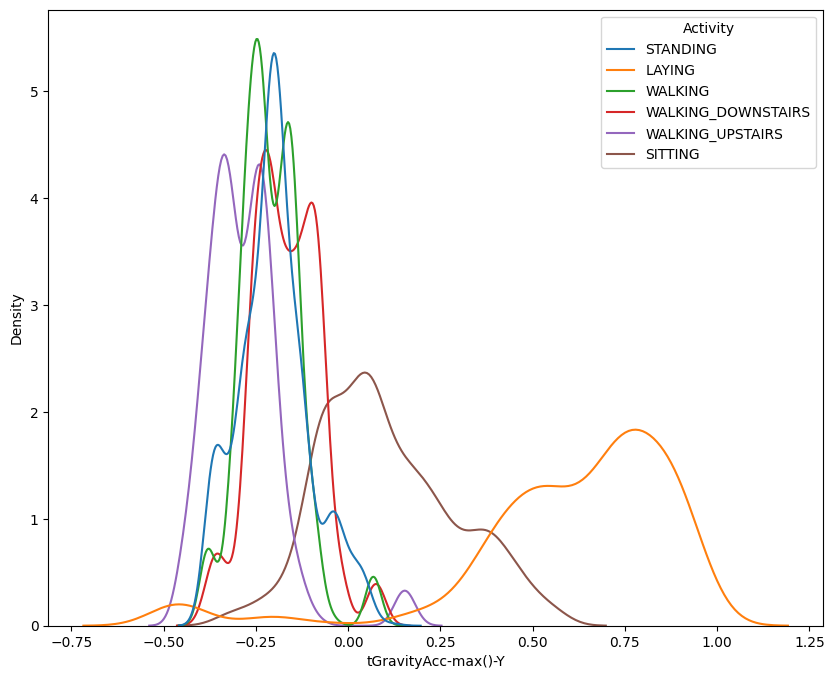

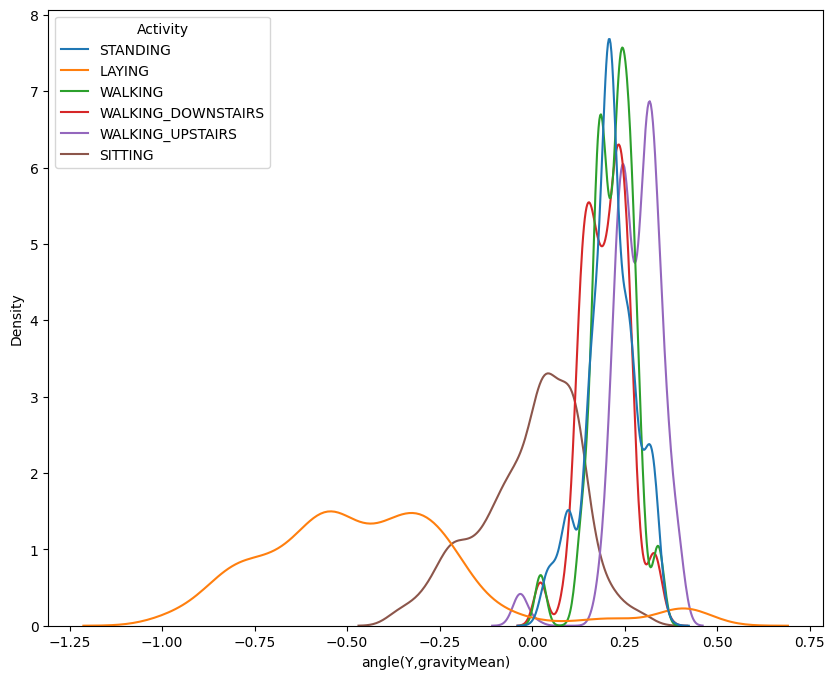

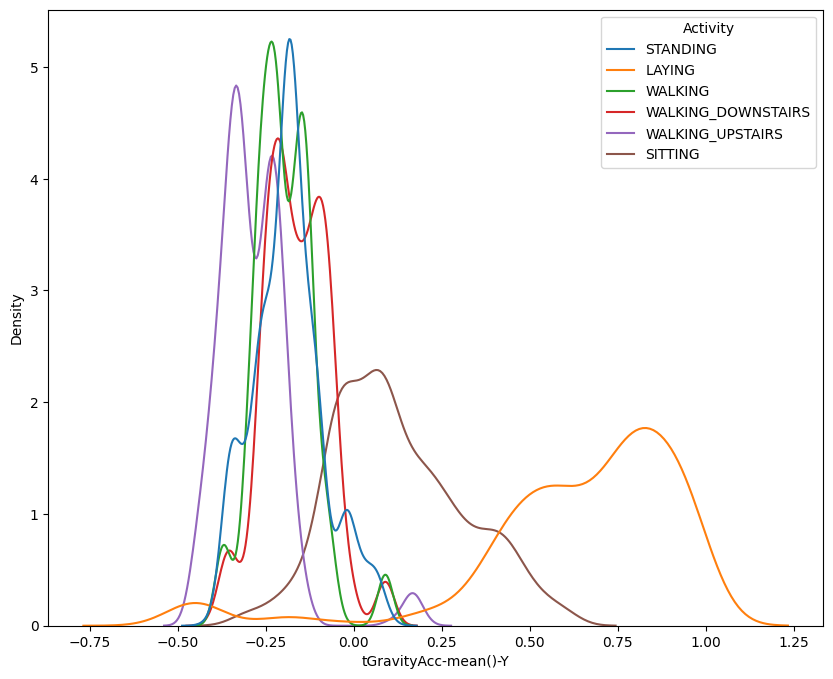

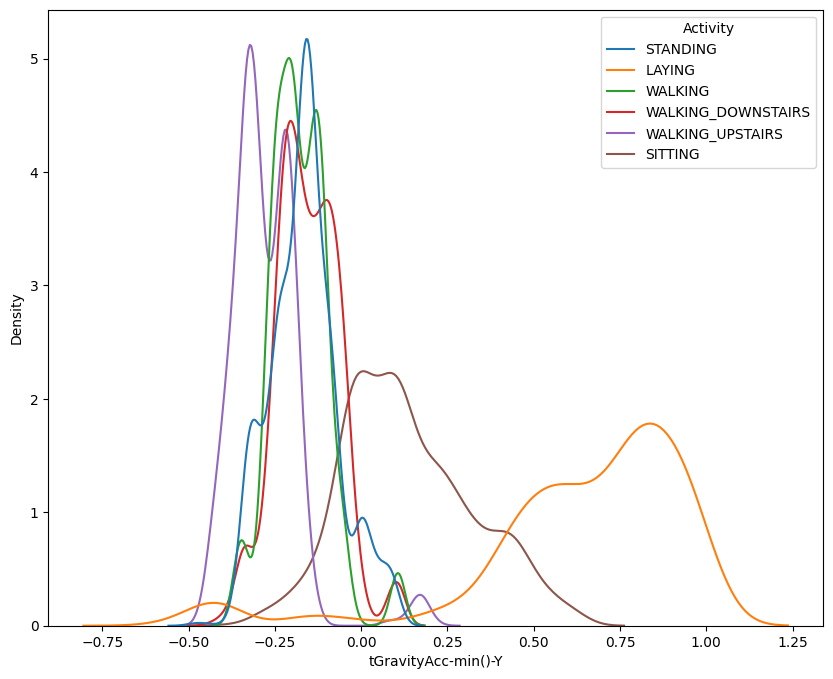

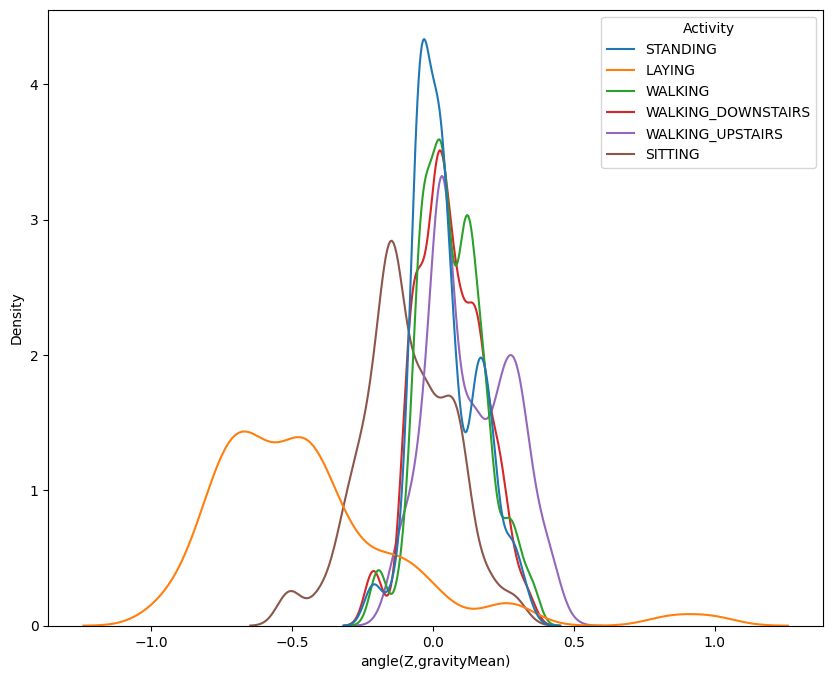

In [43]:
is_standing = y.map({'STANDING':1, 'SITTING':0, 'LAYING':0,
                   'WALKING':0, 'WALKING_UPSTAIRS':0, 'WALKING_DOWNSTAIRS':0})
fi_standing, df_merge = analyze_activity(x, is_standing, "standing")

<Figure size 3000x2000 with 0 Axes>

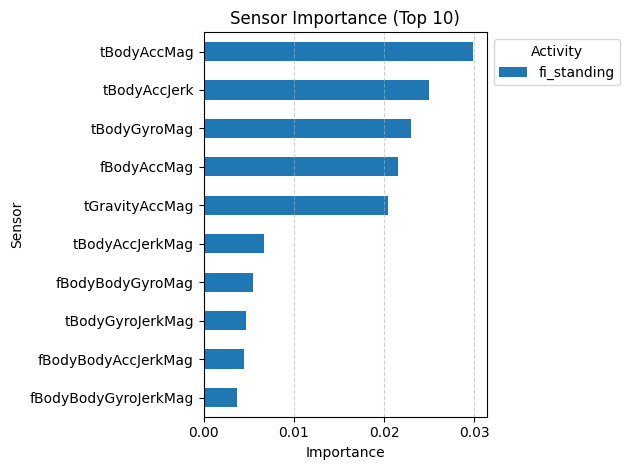

<Figure size 3000x2000 with 0 Axes>

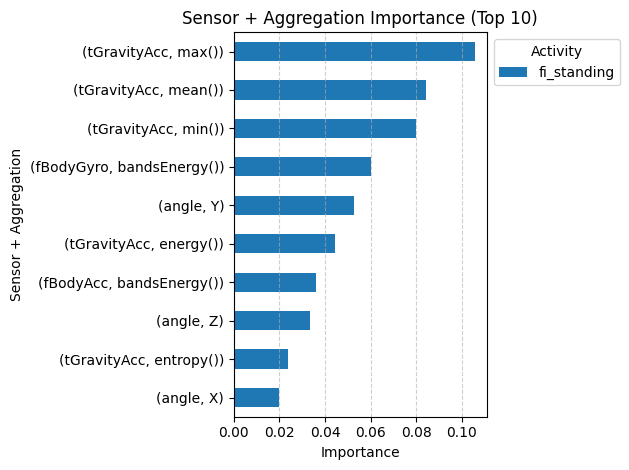

<Figure size 3000x2000 with 0 Axes>

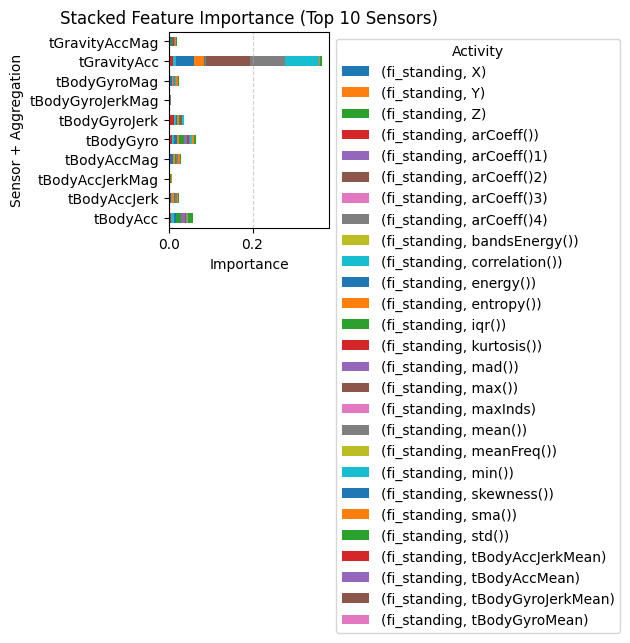

In [44]:
plot_FI(df_merge=df_merge.copy(), activity='fi_standing')

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


** Evaluation for sitting Activity**
accuracy : 0.9818696883852691
[[1434   15]
 [  17  299]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1449
           1       0.95      0.95      0.95       316

    accuracy                           0.98      1765
   macro avg       0.97      0.97      0.97      1765
weighted avg       0.98      0.98      0.98      1765

** Feature Importance for sitting Activity (Top 5)**
           feature_name  fi_sitting
0  angle(Y,gravityMean)    0.049833
1   tGravityAcc-max()-Y    0.038577
2  tGravityAcc-mean()-Y    0.037861
3   tGravityAcc-min()-Y    0.033372
4  tGravityAcc-mean()-X    0.030339
** DataFrame (Top 5) **
     sensor     agg axis       feature_name        FI  fi_dynamic  \
0  tBodyAcc  mean()    X  tBodyAcc-mean()-X  0.000104    0.000062   
1  tBodyAcc  mean()    Y  tBodyAcc-mean()-Y  0.000345    0.000020   
2  tBodyAcc  mean()    Z  tBodyAcc-mean()-Z  0.000099    0.000029   
3  tBodyAc

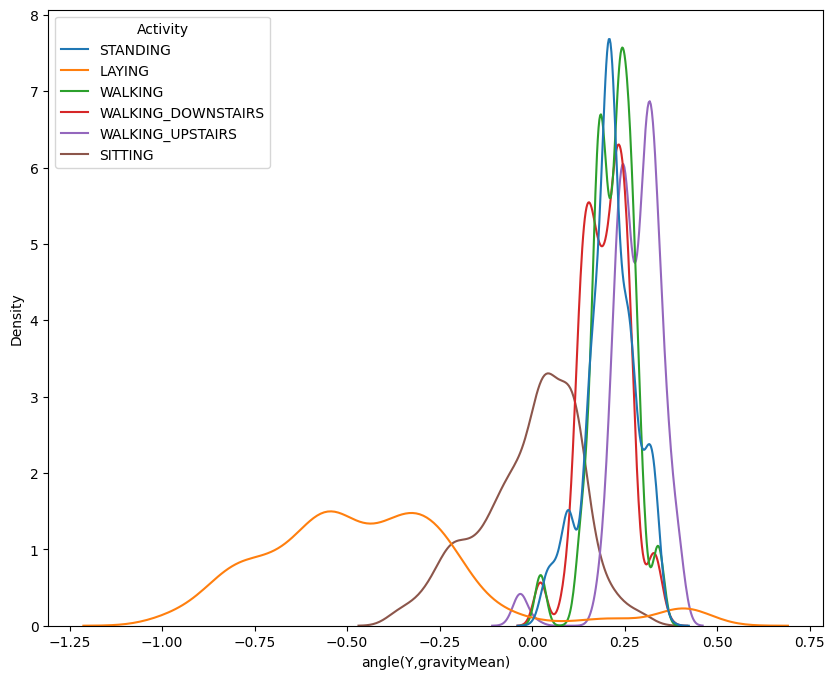

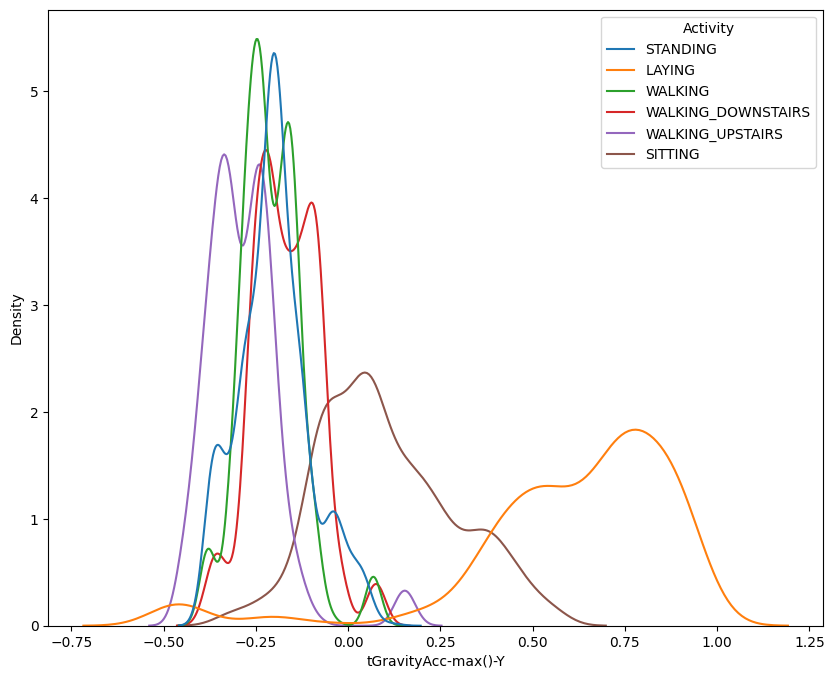

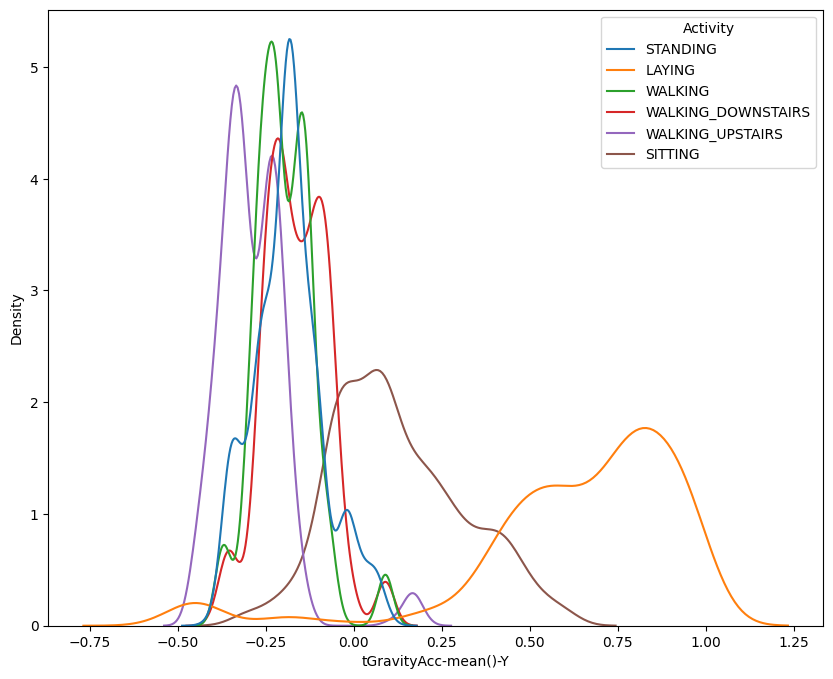

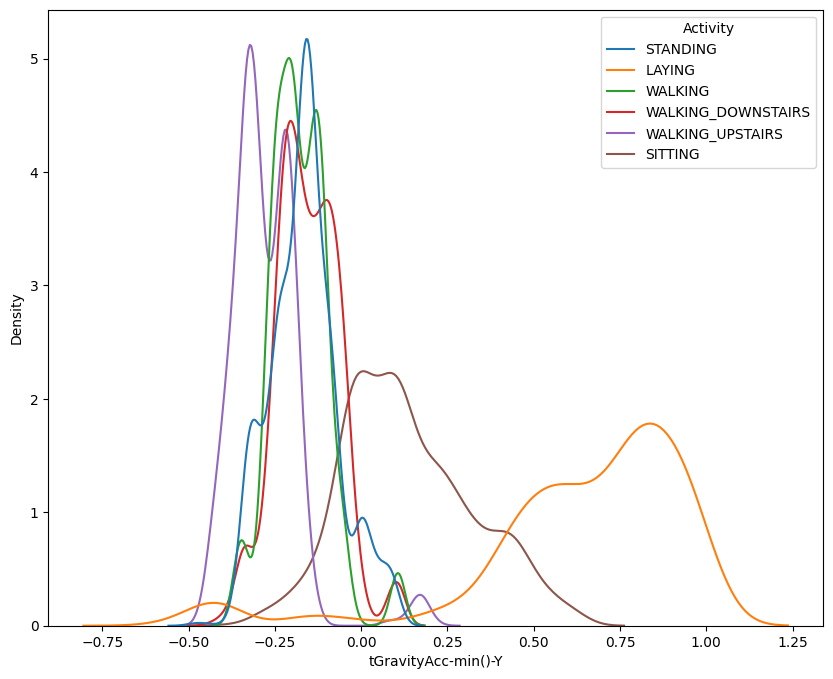

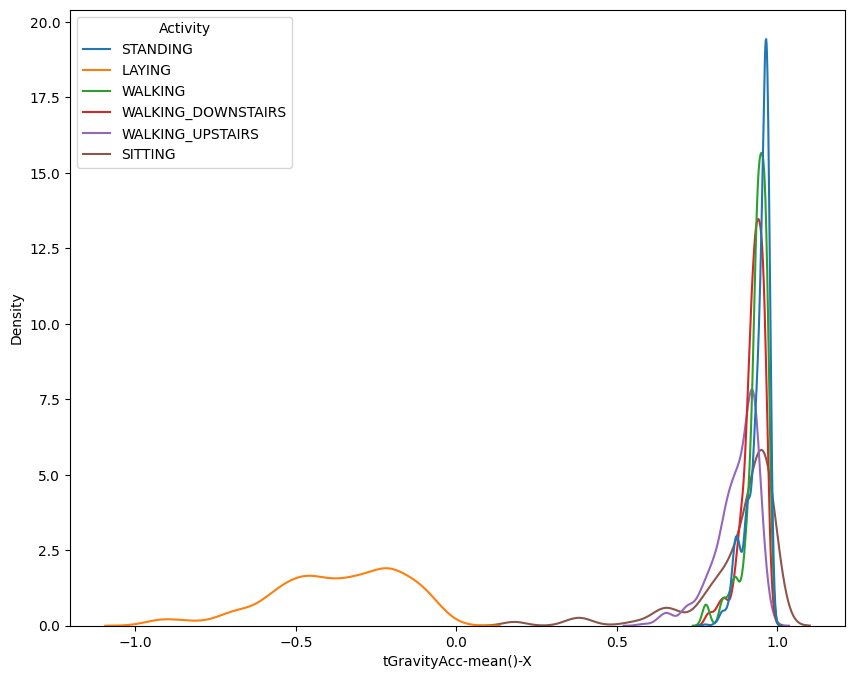

In [45]:
is_sitting = y.map({'STANDING':0, 'SITTING':1, 'LAYING':0,
                   'WALKING':0, 'WALKING_UPSTAIRS':0, 'WALKING_DOWNSTAIRS':0})
fi_sitting, df_merge = analyze_activity(x, is_sitting, "sitting")

<Figure size 3000x2000 with 0 Axes>

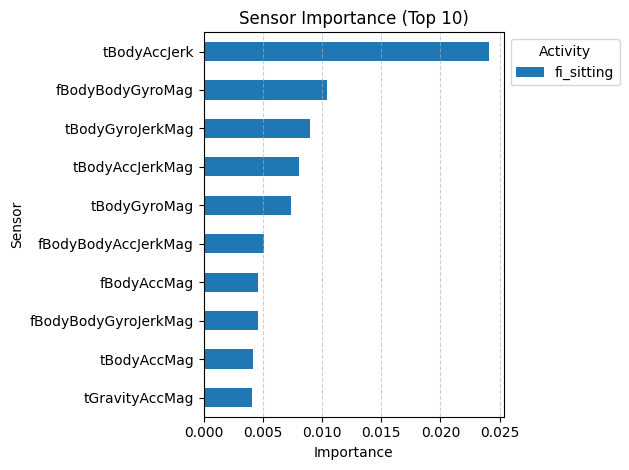

<Figure size 3000x2000 with 0 Axes>

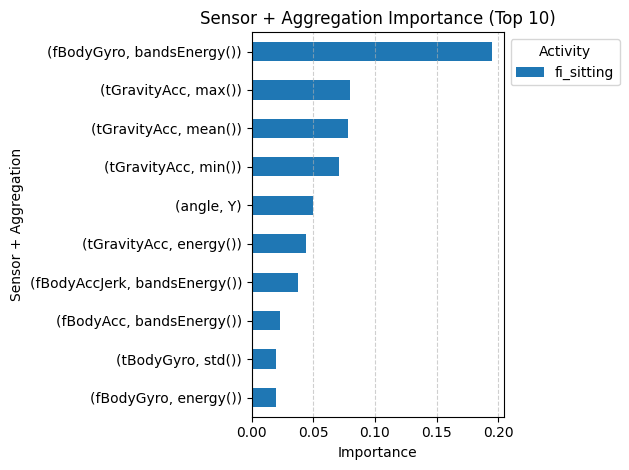

<Figure size 3000x2000 with 0 Axes>

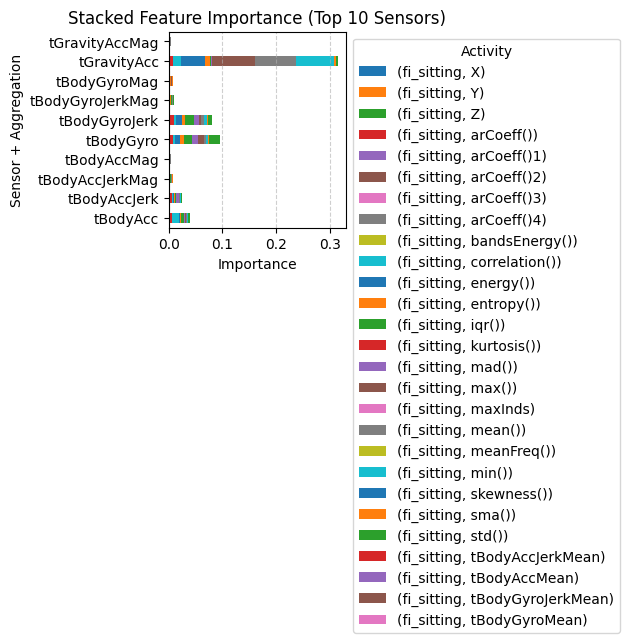

In [46]:
plot_FI(df_merge=df_merge.copy(), activity='fi_sitting')

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


** Evaluation for laying Activity**
accuracy : 1.0
[[1434    0]
 [   0  331]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1434
           1       1.00      1.00      1.00       331

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765

** Feature Importance for laying Activity (Top 5)**
             feature_name  fi_laying
0  tGravityAcc-energy()-X   0.115898
1     tGravityAcc-min()-X   0.100717
2     tGravityAcc-min()-Y   0.085198
3    angle(X,gravityMean)   0.071118
4     tGravityAcc-max()-X   0.061658
** DataFrame (Top 5) **
     sensor     agg axis       feature_name        FI  fi_dynamic  \
0  tBodyAcc  mean()    X  tBodyAcc-mean()-X  0.000104    0.000062   
1  tBodyAcc  mean()    Y  tBodyAcc-mean()-Y  0.000345    0.000020   
2  tBodyAcc  mean()    Z  tBodyAcc-mean()-Z  0.000099    0.000029   
3  tBodyAcc   std()  

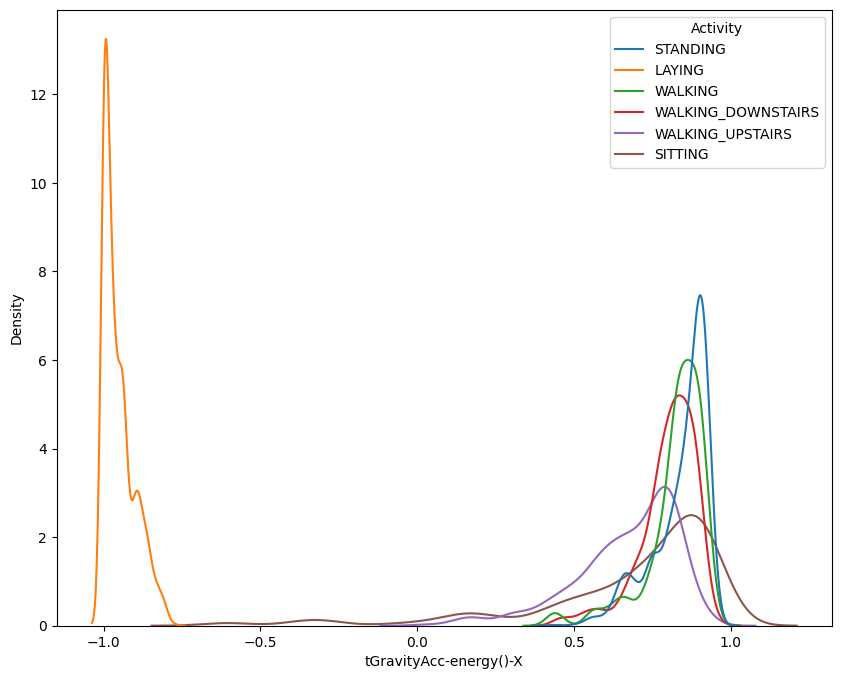

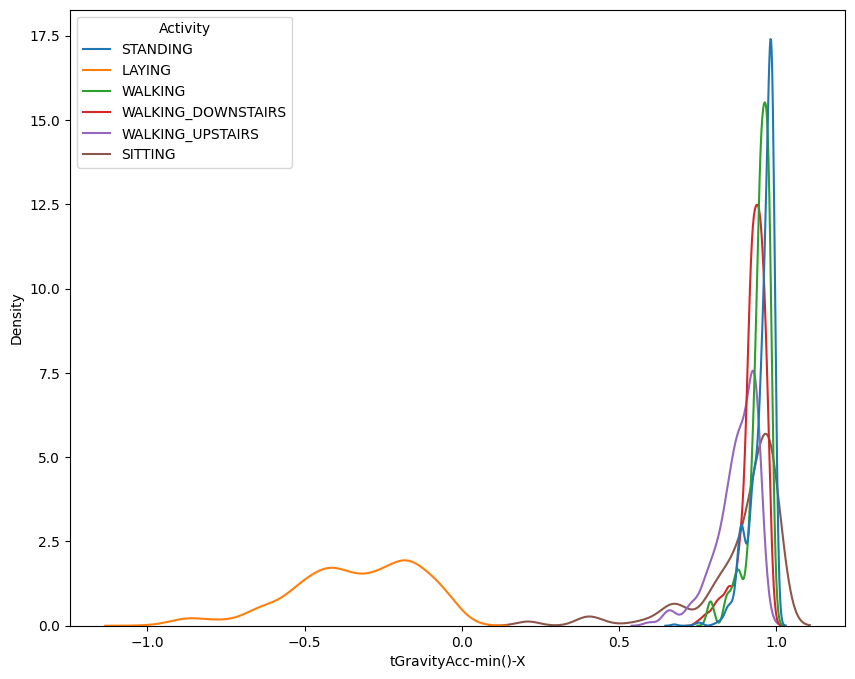

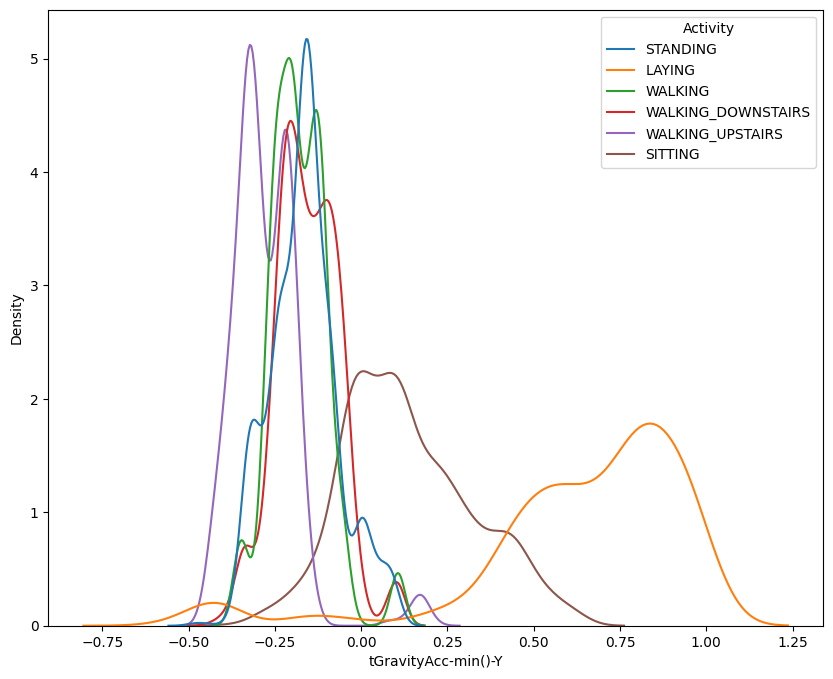

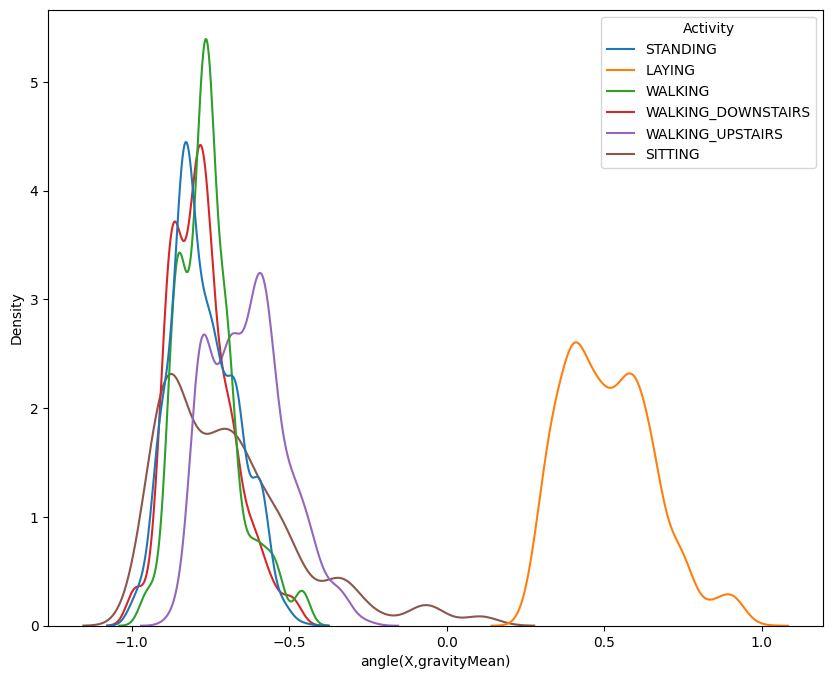

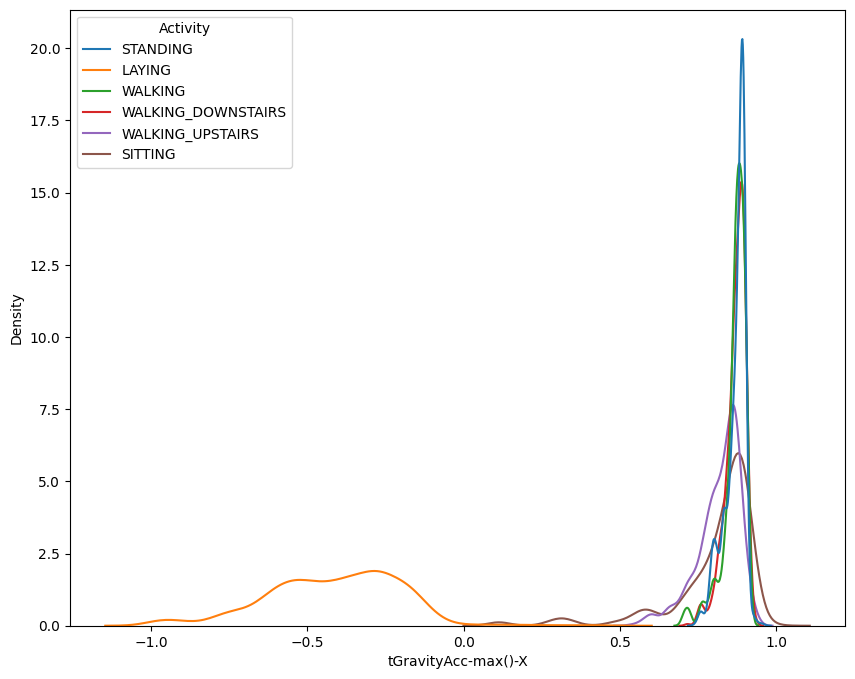

In [47]:
is_laying = y.map({'STANDING':0, 'SITTING':0, 'LAYING':1,
                   'WALKING':0, 'WALKING_UPSTAIRS':0, 'WALKING_DOWNSTAIRS':0})
fi_laying, df_merge = analyze_activity(x, is_laying, "laying")

<Figure size 3000x2000 with 0 Axes>

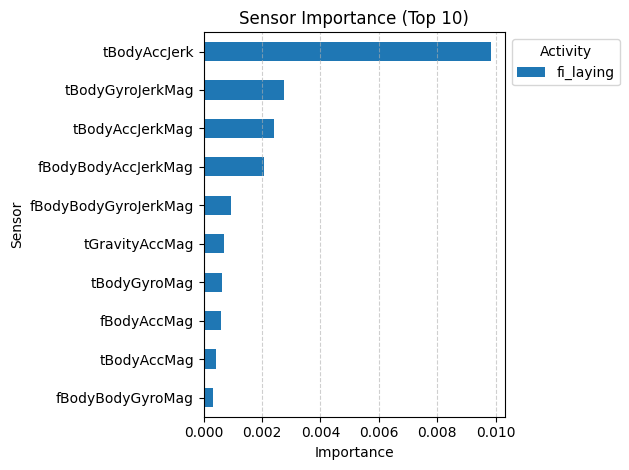

<Figure size 3000x2000 with 0 Axes>

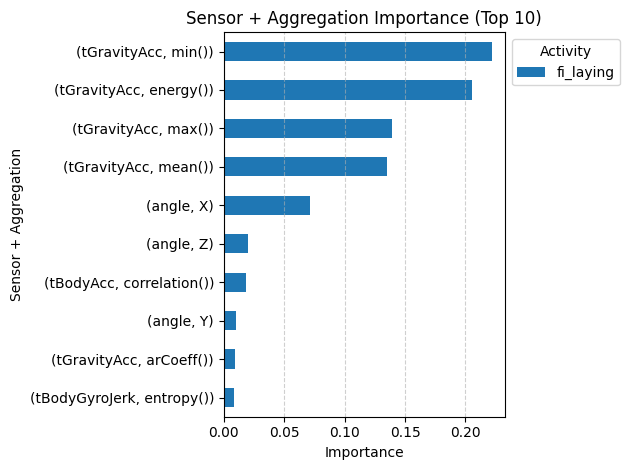

<Figure size 3000x2000 with 0 Axes>

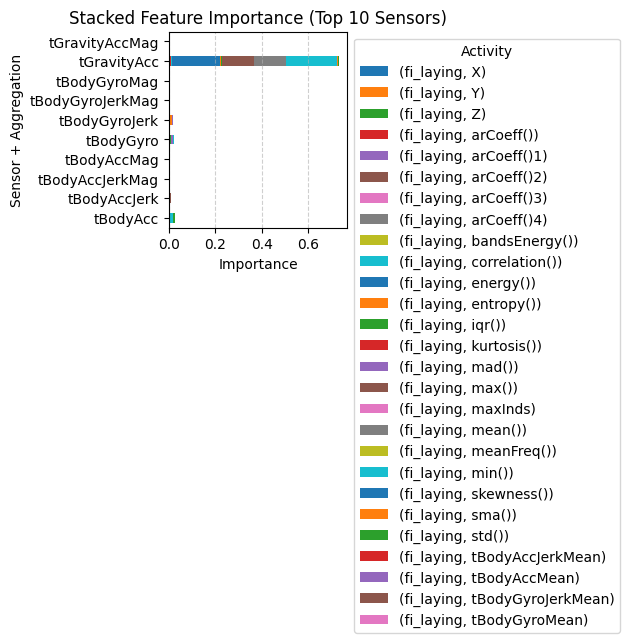

In [48]:
plot_FI(df_merge=df_merge.copy(), activity='fi_laying')

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


** Evaluation for walking Activity**
accuracy : 0.996600566572238
[[1450    1]
 [   5  309]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1451
           1       1.00      0.98      0.99       314

    accuracy                           1.00      1765
   macro avg       1.00      0.99      0.99      1765
weighted avg       1.00      1.00      1.00      1765

** Feature Importance for walking Activity (Top 5)**
                        feature_name  fi_walking
0                   fBodyAcc-max()-X    0.022024
1         fBodyAcc-bandsEnergy()-1,8    0.021994
2  fBodyAccJerk-bandsEnergy()-1,24.1    0.020393
3          tGravityAcc-arCoeff()-X,1    0.019341
4         tBodyAcc-correlation()-X,Y    0.018468
** DataFrame (Top 5) **
     sensor     agg axis       feature_name        FI  fi_dynamic  \
0  tBodyAcc  mean()    X  tBodyAcc-mean()-X  0.000104    0.000062   
1  tBodyAcc  mean()    Y  tBodyAcc-mean()-Y  0.000345    0.000020   
2 

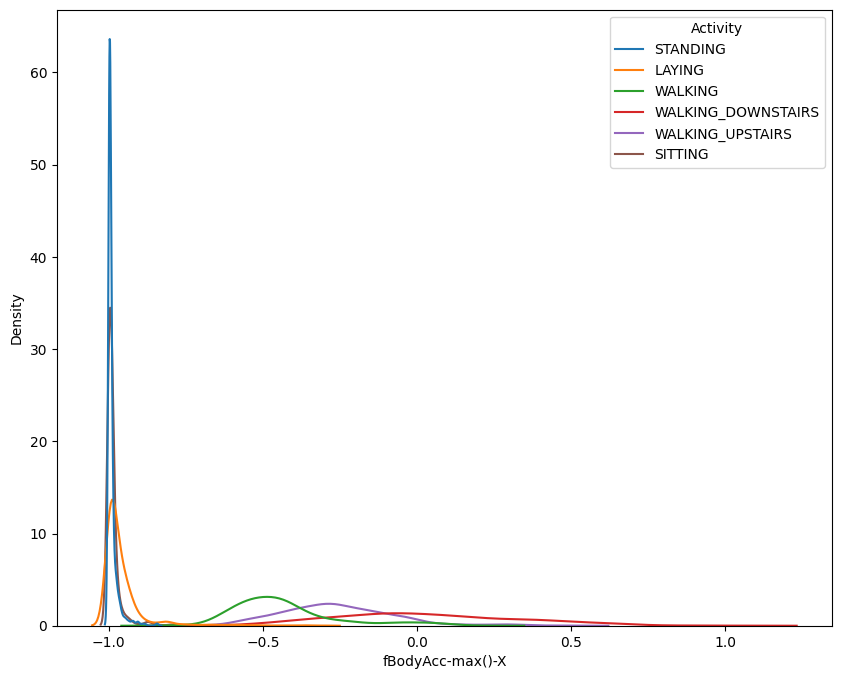

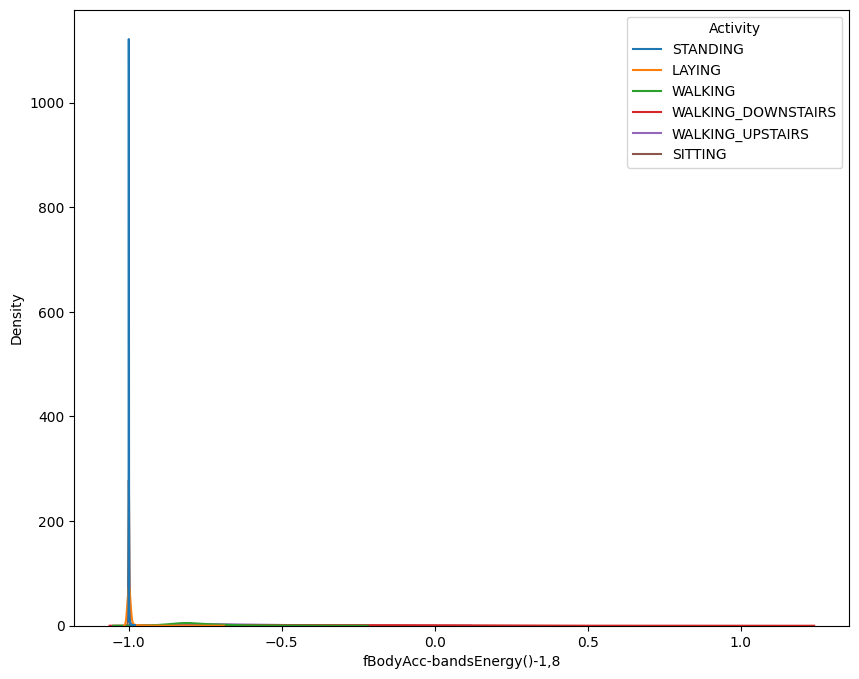

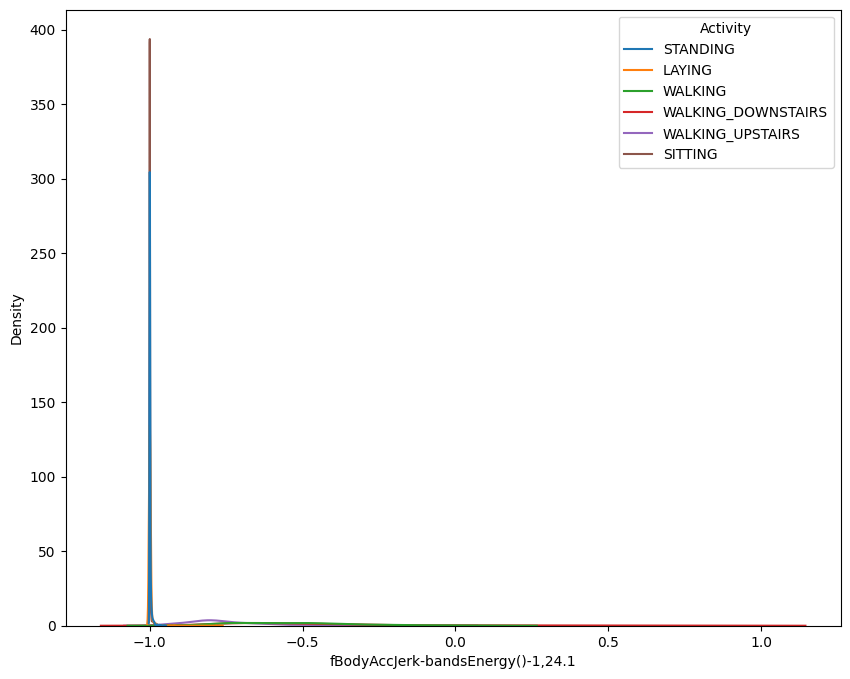

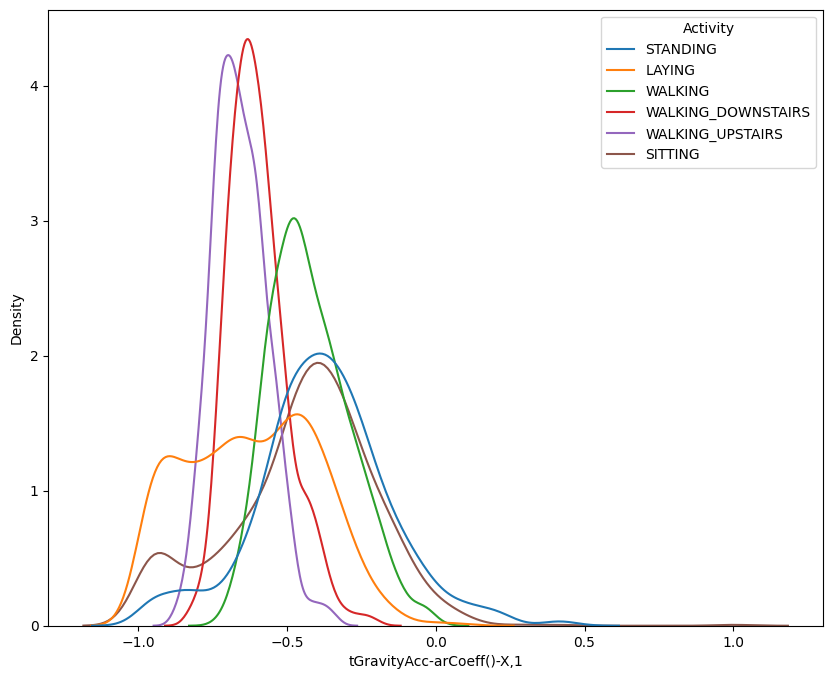

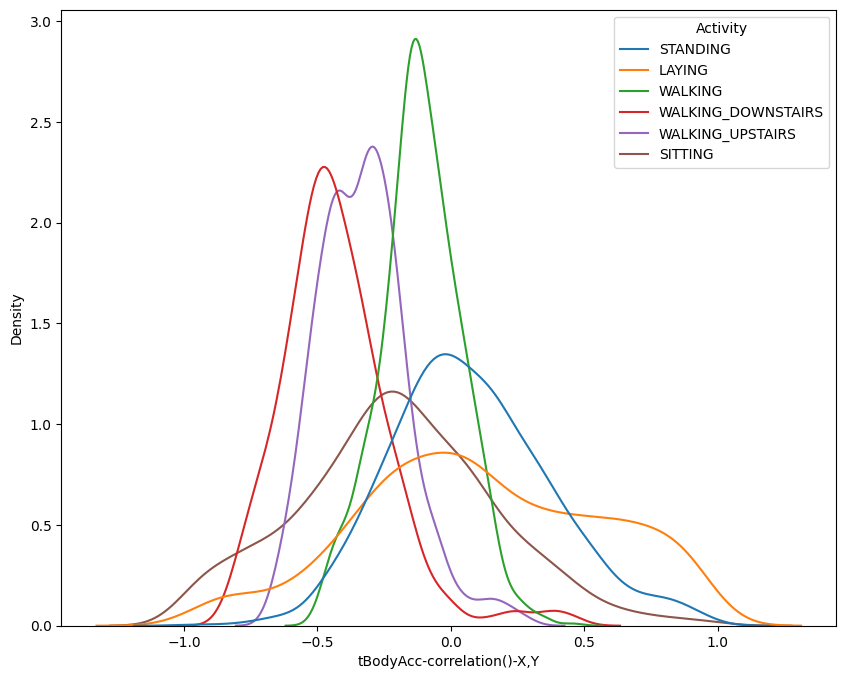

In [49]:
is_walking = y.map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                   'WALKING':1, 'WALKING_UPSTAIRS':0, 'WALKING_DOWNSTAIRS':0})
fi_walking, df_merge = analyze_activity(x, is_walking, "walking")

<Figure size 3000x2000 with 0 Axes>

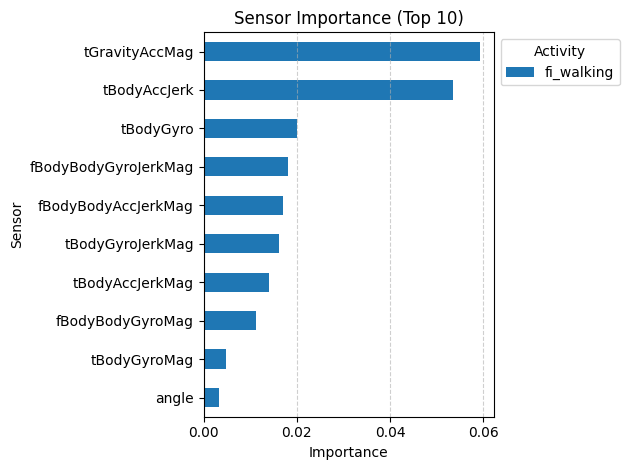

<Figure size 3000x2000 with 0 Axes>

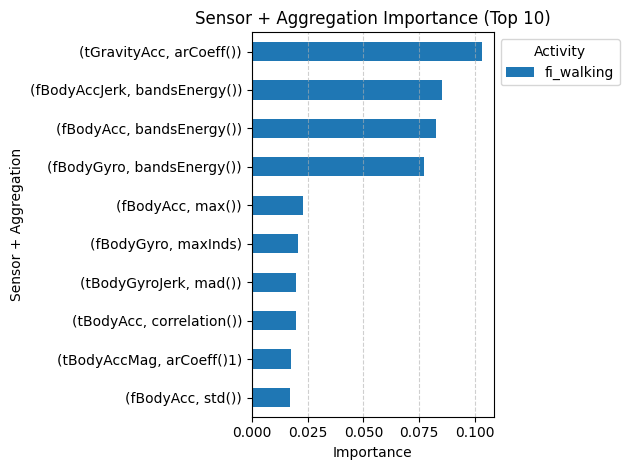

<Figure size 3000x2000 with 0 Axes>

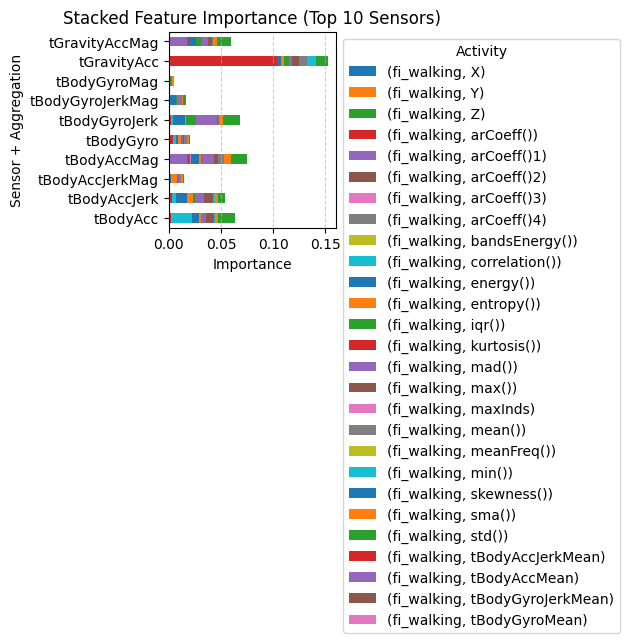

In [50]:
plot_FI(df_merge=df_merge.copy(), activity='fi_walking')

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


** Evaluation for walking_up Activity**
accuracy : 0.9977337110481587
[[1504    1]
 [   3  257]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       1.00      0.99      0.99       260

    accuracy                           1.00      1765
   macro avg       1.00      0.99      1.00      1765
weighted avg       1.00      1.00      1.00      1765

** Feature Importance for walking_up Activity (Top 5)**
                feature_name  fi_walking_up
0  tGravityAcc-arCoeff()-Z,1       0.034055
1  tGravityAcc-arCoeff()-Z,2       0.032665
2        tGravityAcc-min()-Y       0.030825
3  tGravityAcc-arCoeff()-Z,3       0.027146
4  tGravityAcc-arCoeff()-Z,4       0.022235
** DataFrame (Top 5) **
     sensor     agg axis       feature_name        FI  fi_dynamic  \
0  tBodyAcc  mean()    X  tBodyAcc-mean()-X  0.000104    0.000062   
1  tBodyAcc  mean()    Y  tBodyAcc-mean()-Y  0.000345    0.000020   
2  tBodyAcc  mean()    Z 

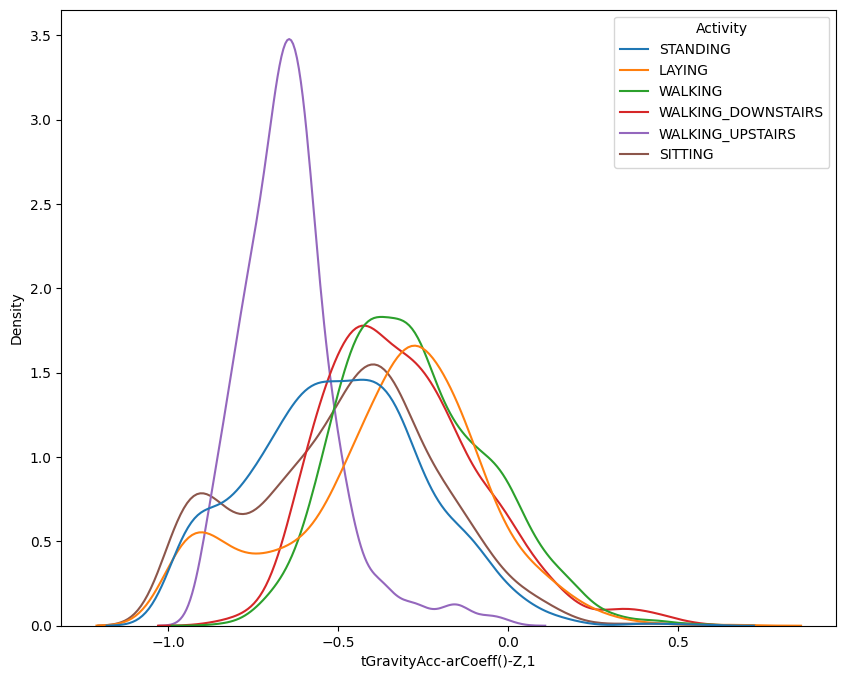

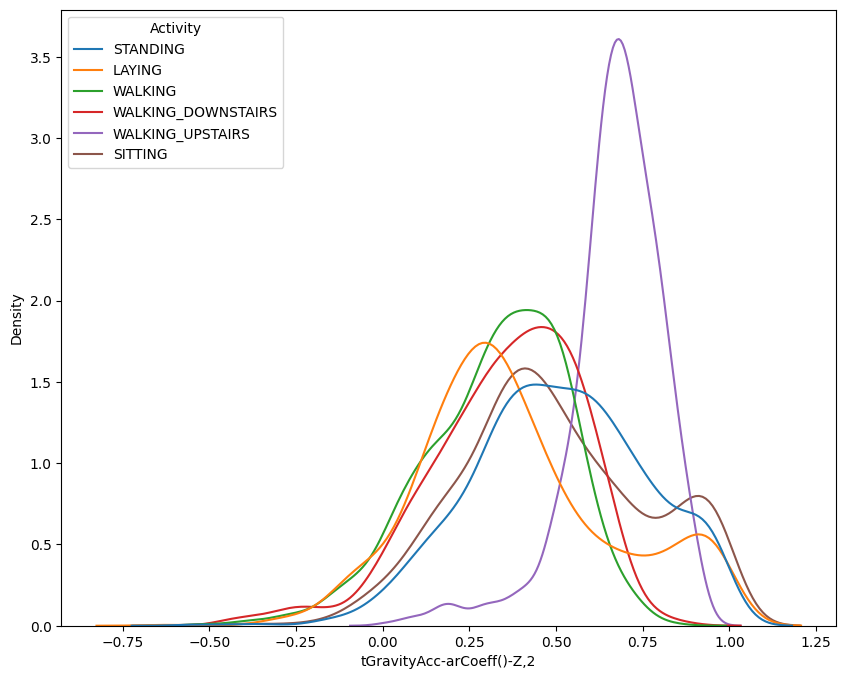

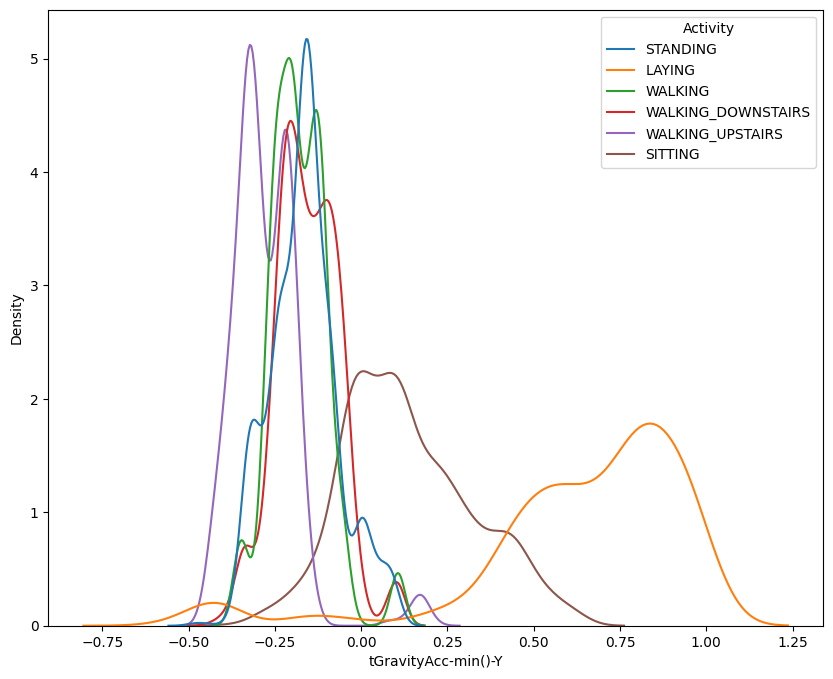

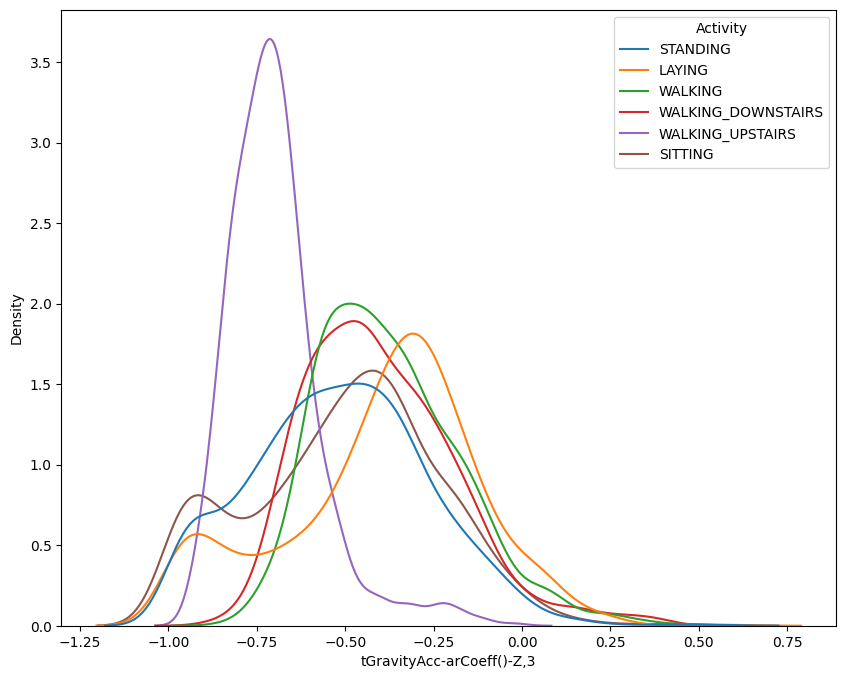

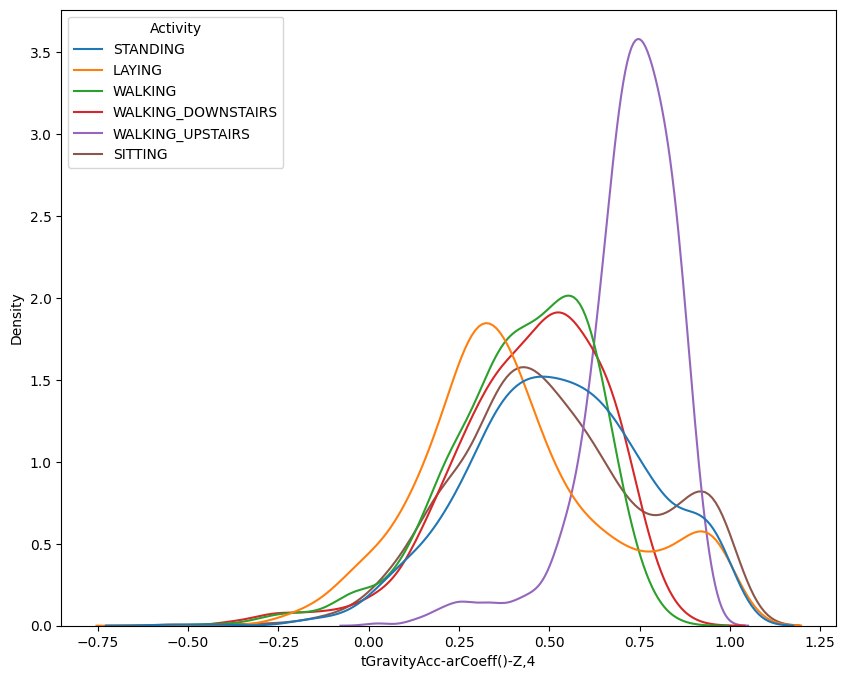

In [51]:
is_walking_up = y.map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                   'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':0})
fi_walking_up, df_merge = analyze_activity(x, is_walking_up, "walking_up")

<Figure size 3000x2000 with 0 Axes>

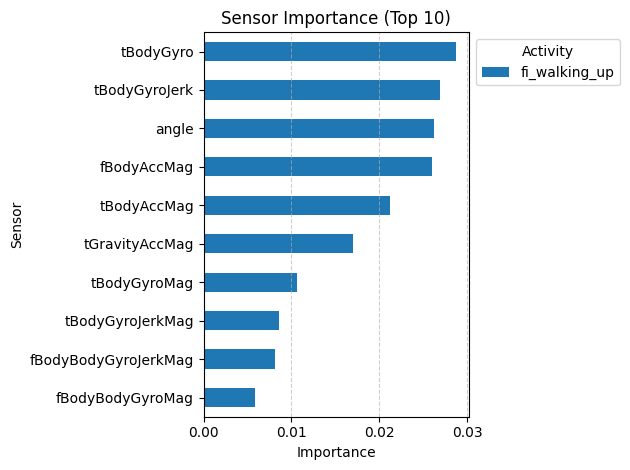

<Figure size 3000x2000 with 0 Axes>

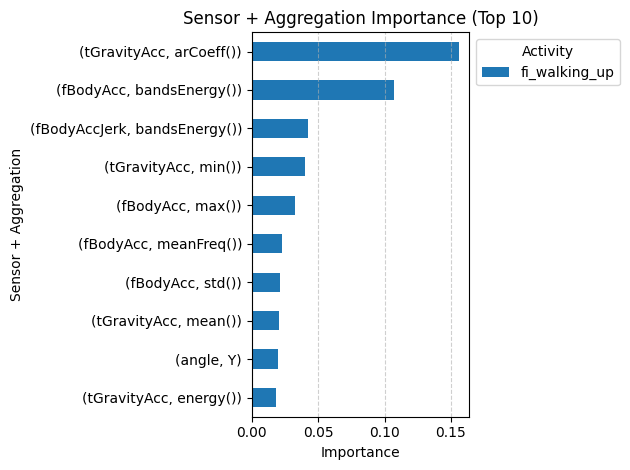

<Figure size 3000x2000 with 0 Axes>

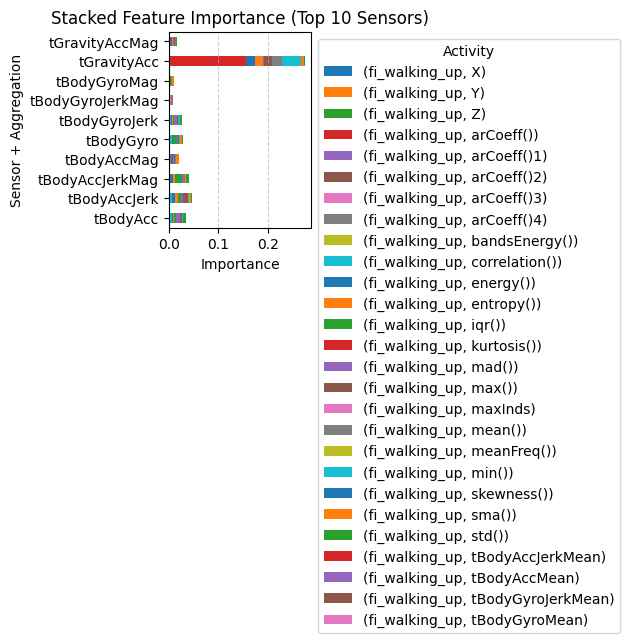

In [52]:
plot_FI(df_merge=df_merge.copy(), activity='fi_walking_up')

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


** Evaluation for walking_down Activity**
accuracy : 0.9892351274787535
[[1518    2]
 [  17  228]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1520
           1       0.99      0.93      0.96       245

    accuracy                           0.99      1765
   macro avg       0.99      0.96      0.98      1765
weighted avg       0.99      0.99      0.99      1765

** Feature Importance for walking_down Activity (Top 5)**
                  feature_name  fi_walking_down
0         tGravityAccMag-std()         0.049222
1             fBodyAcc-mad()-X         0.045864
2             tBodyAcc-max()-X         0.043340
3  fBodyAcc-bandsEnergy()-1,24         0.037293
4            fBodyAccMag-mad()         0.034680
** DataFrame (Top 5) **
     sensor     agg axis       feature_name        FI  fi_dynamic  \
0  tBodyAcc  mean()    X  tBodyAcc-mean()-X  0.000104    0.000062   
1  tBodyAcc  mean()    Y  tBodyAcc-mean()-Y  0.000345    0.000020 

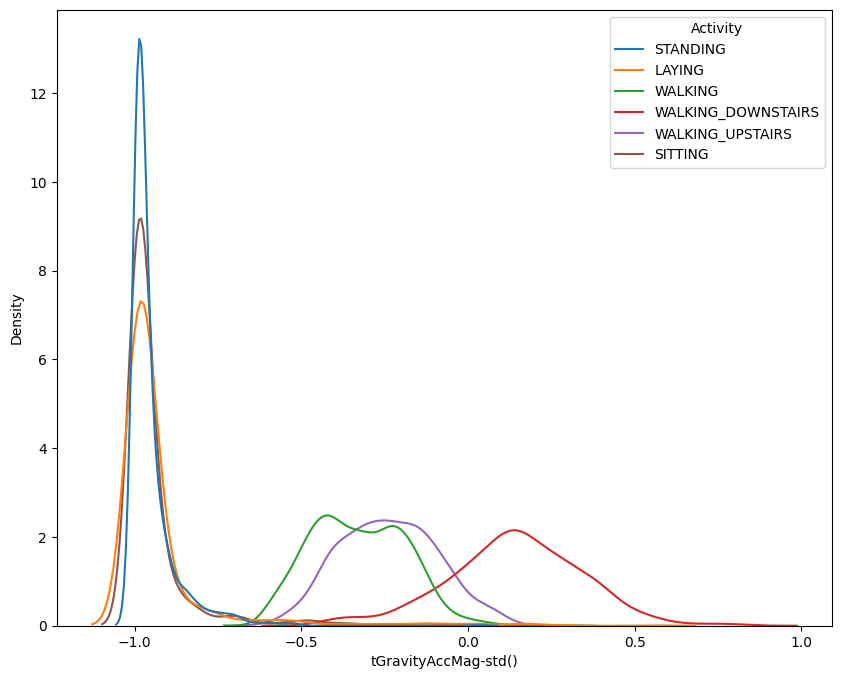

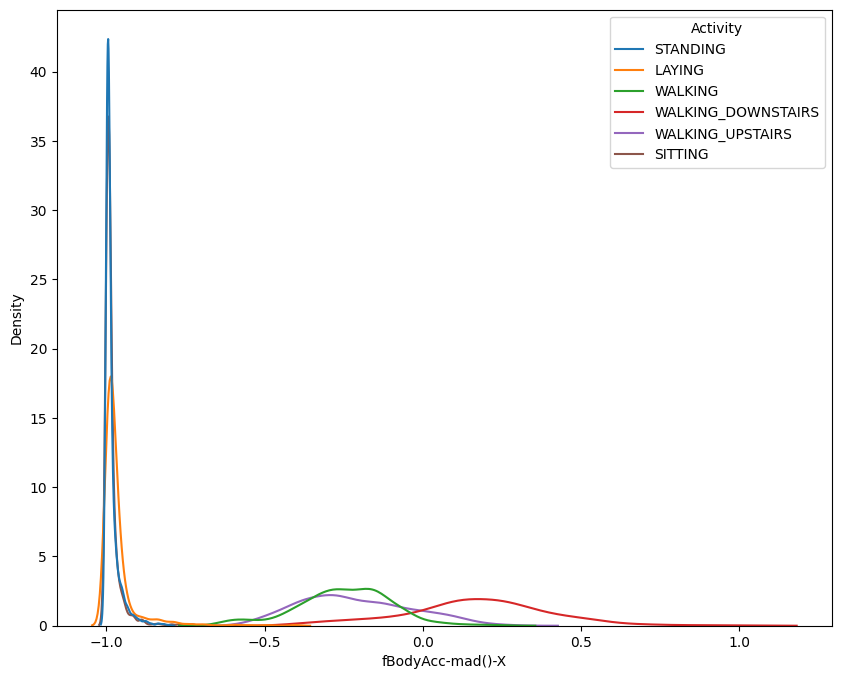

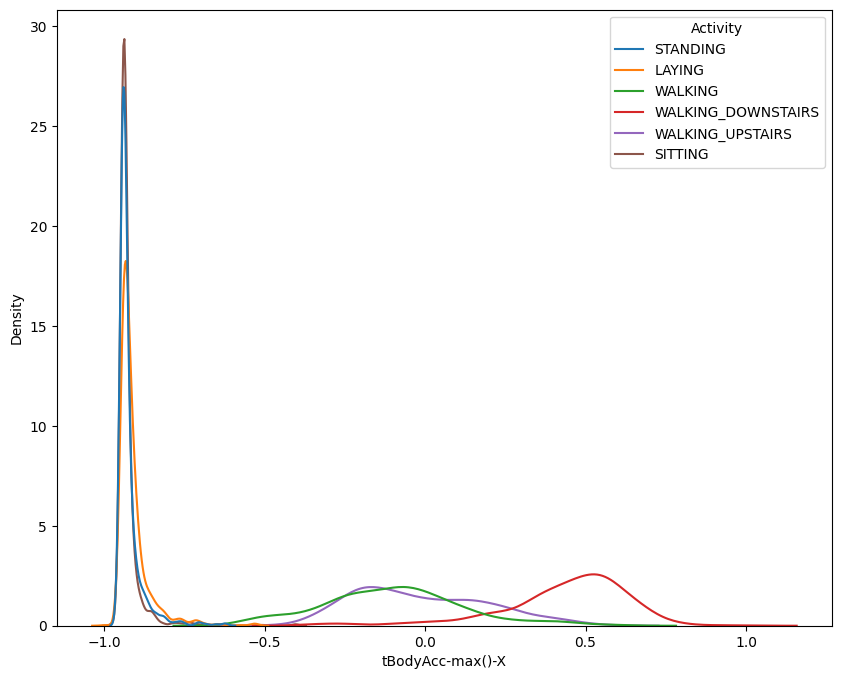

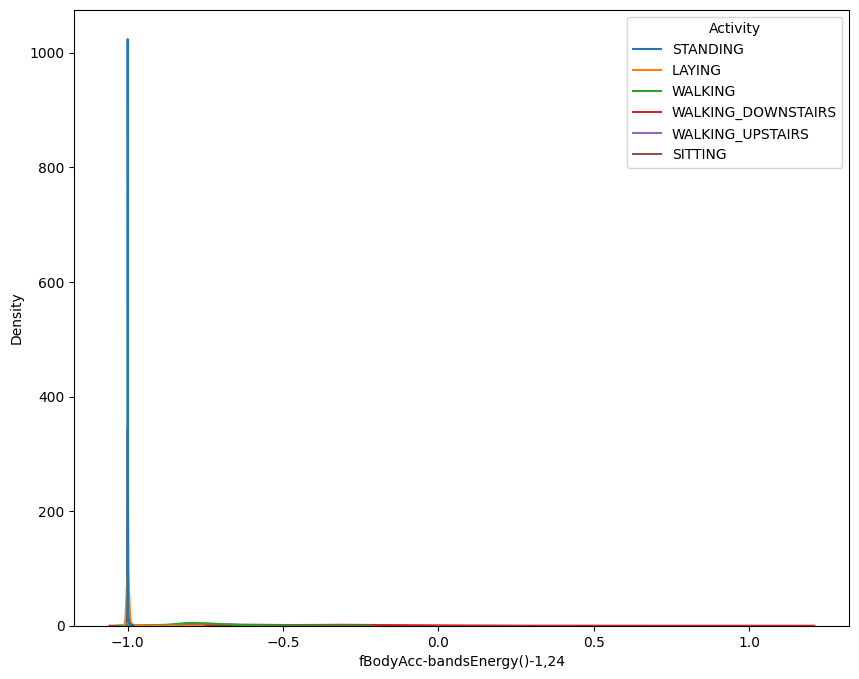

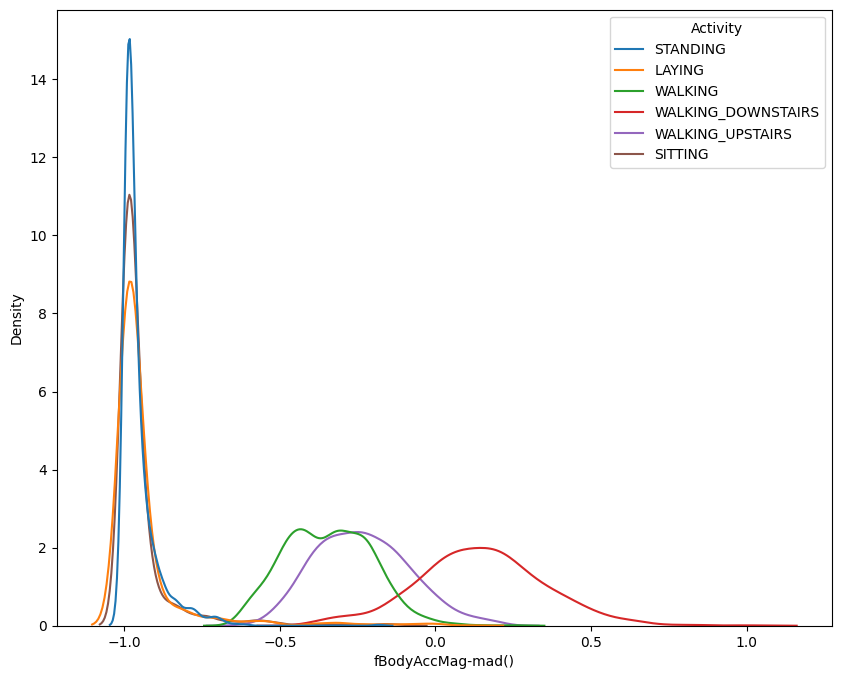

In [53]:
is_walking_down = y.map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                   'WALKING':0, 'WALKING_UPSTAIRS':0, 'WALKING_DOWNSTAIRS':1})
fi_walking_down, df_merge = analyze_activity(x, is_walking_down, "walking_down")

<Figure size 3000x2000 with 0 Axes>

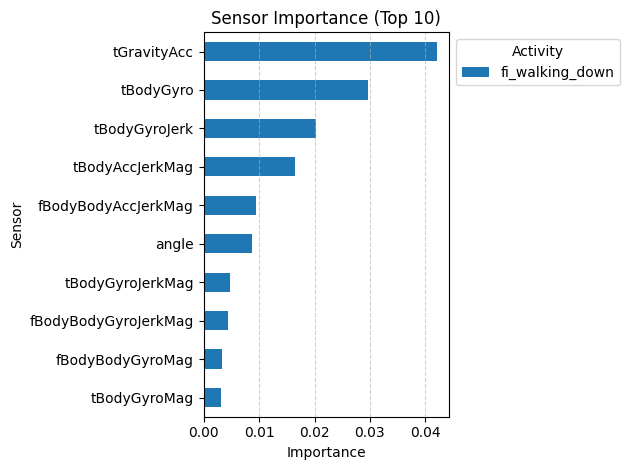

<Figure size 3000x2000 with 0 Axes>

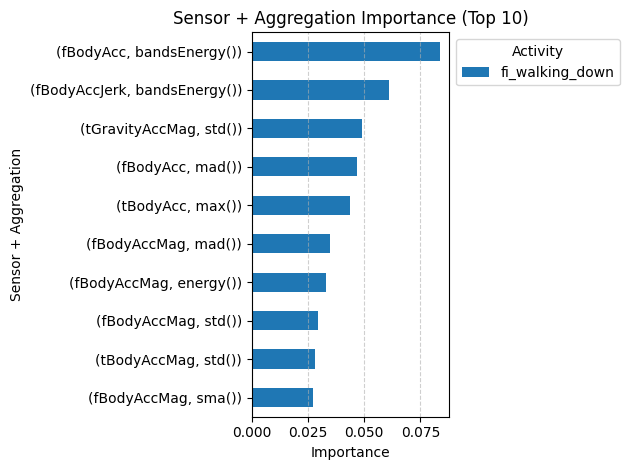

<Figure size 3000x2000 with 0 Axes>

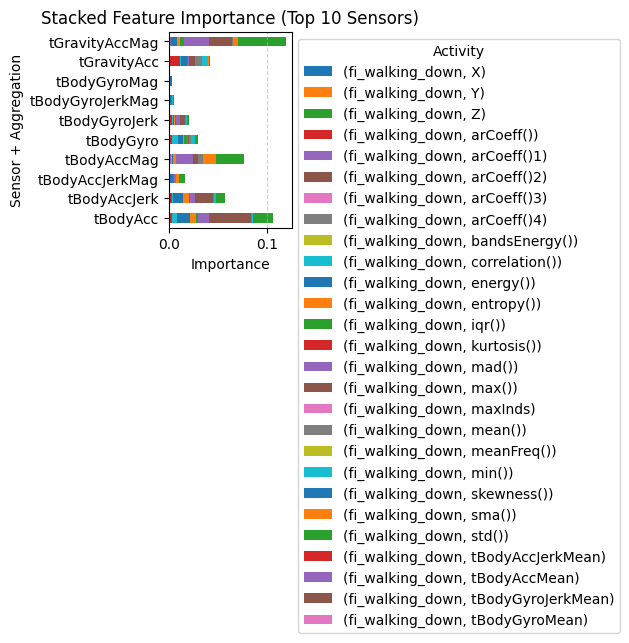

In [54]:
plot_FI(df_merge=df_merge.copy(), activity='fi_walking_down')

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

In [55]:
# FI_plot 과정에서 이미 하나씩 Merge 했음
df_merge

sensor     agg axis                     feature_name        FI  \
0    tBodyAcc  mean()    X                tBodyAcc-mean()-X  0.000104   
1    tBodyAcc  mean()    Y                tBodyAcc-mean()-Y  0.000345   
2    tBodyAcc  mean()    Z                tBodyAcc-mean()-Z  0.000099   
3    tBodyAcc   std()    X                 tBodyAcc-std()-X  0.003936   
4    tBodyAcc   std()    Y                 tBodyAcc-std()-Y  0.000644   
..        ...     ...  ...                              ...       ...   
586       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-57,64.1  0.000174   
587       NaN     NaN  NaN   fBodyGyro-bandsEnergy()-1,24.1  0.000157   
588       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-49,56.1  0.000146   
589       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-41,48.1  0.000127   
590       NaN     NaN  NaN  fBodyGyro-bandsEnergy()-33,48.1  0.000123   

     fi_dynamic  fi_standing  fi_sitting  fi_laying  fi_walking  \
0      0.000062     0.000179    0.000640   0.000207    0.000092   
1      0.000020     0.000429    0.000384   0.000000    0.000184   
2      0.000029     0.000299    0.000218   0.000000    0.000129   
3      0.000059     0.007551    0.001678   0.000572    0.015968   
4      0.000000     0.002562    0.000561   0.000295    0.000120   
..          ...          ...         ...        ...         ...   
586    0.000000     0.000281    0.000423   0.000050    0.000224   
587    0.000000     0.000960    0.000972   0.002013    0.000309   
588    0.000000     0.000662    0.000411   0.000026    0.000148   
589    0.000000     0.000252    0.000596   0.000167    0.000141   
590    0.000000     0.000247    0.000384   0.000064    0.000094   

     fi_walking_up  fi_walking_down  
0         0.000313         0.000296  
1         0.000301         0.000361  
2         0.000586         0.000174  
3         0.003428         0.018447  
4         0.000964         0.001023  
..             ...              ...  
586       0.000134         0.000086  
587       0.000175         0.000318  
588       0.000146         0.000154  
589       0.000171         0.000380  
590       0.000136         0.000624  

[591 rows x 12 columns]

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [58]:
joblib.dump(df_merge, os.path.join(os.getcwd(), 'data/data_merge.pkl'))

['/Users/leechangmin/Desktop/Project/AIX/(제공용)스마트폰센스 교안, 데이터 및 실습 과제/src/data/data_merge.pkl']